# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 11.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [87]:
!pip install folium

In [88]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

In [139]:
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['font.size'] = 12
sns.set_style('darkgrid')

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [91]:
!wget -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = pd.read_csv('train.csv')

In [ ]:
df.head(10)

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = df.drop(columns=['dropoff_datetime'])

In [ ]:
df.loc[:, 'pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [ ]:
df.head(10).dtypes

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

Я знаю, что у нас есть выбросы, поэтому нарисуем распределение таргета в обучающей выборке без выбросов и с ними

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
hist = df[df['trip_duration'] < 10000].hist('trip_duration', bins=50, density=True)
plt.xlabel('Trip duraion')
plt.ylabel('Density')
plt.title('Density of trip duration without outliers')
plt.show()

In [ ]:
hist = df[df['trip_duration'] >= 10000].hist('trip_duration', bins=50, density=True)
plt.xlabel('Trip duraion')
plt.ylabel('Density')
plt.title('Density of outliers of trip duration')
plt.show()

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

Не считая выбросов, можно считать целевую переменную логнормальной.

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

RMSLE штрафует за то, во сколько раз больше/меньше в среднем (средне-логарифмическом?) мы предсказываем время поездки, т.к. при длительных поездках небольшая относительная ошибка в предсказании может быть большой в абсолюном значении, и наоборот - при коротких поездках большая относительная ошибка в предсказании может быть большой в абсолюном значении. Сравнивая с RMSE - мы штрафуем больше за приуменьшение таргета нежели за приувеличение таргета, т.к. если говорить про применения - люди могут полагаться на "примерное" время поездки, и у них могут возникнуть проблемы (опоздают куда-нибудь, хз), если поездка затянется относительно предсказанного, нежели поездка займет меньше предсказанного (успеют на встречу пораньше)

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Пусть $f(x) = \ln{(x + 1)}$ - монотонно возрастающая функция на $[0, +\infty)$

Заметим, что $RMSLE(X, y, a) \equiv RMSE(X, f(y), f \circ a)$, и так как $f(x)$ является монотонно возрастающей функцией, а $f \circ a$ - то, что мы определили как $\hat{a}$, то точки экстремума для $RMSLE(X, y, a)$ совпадают с таковыми у $RMSE(X, f(y), f \circ a)$ ввиду биективности $f$. Значит, оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$


Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [100]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['log_trip_duration'] = np.log1p(df['trip_duration'])

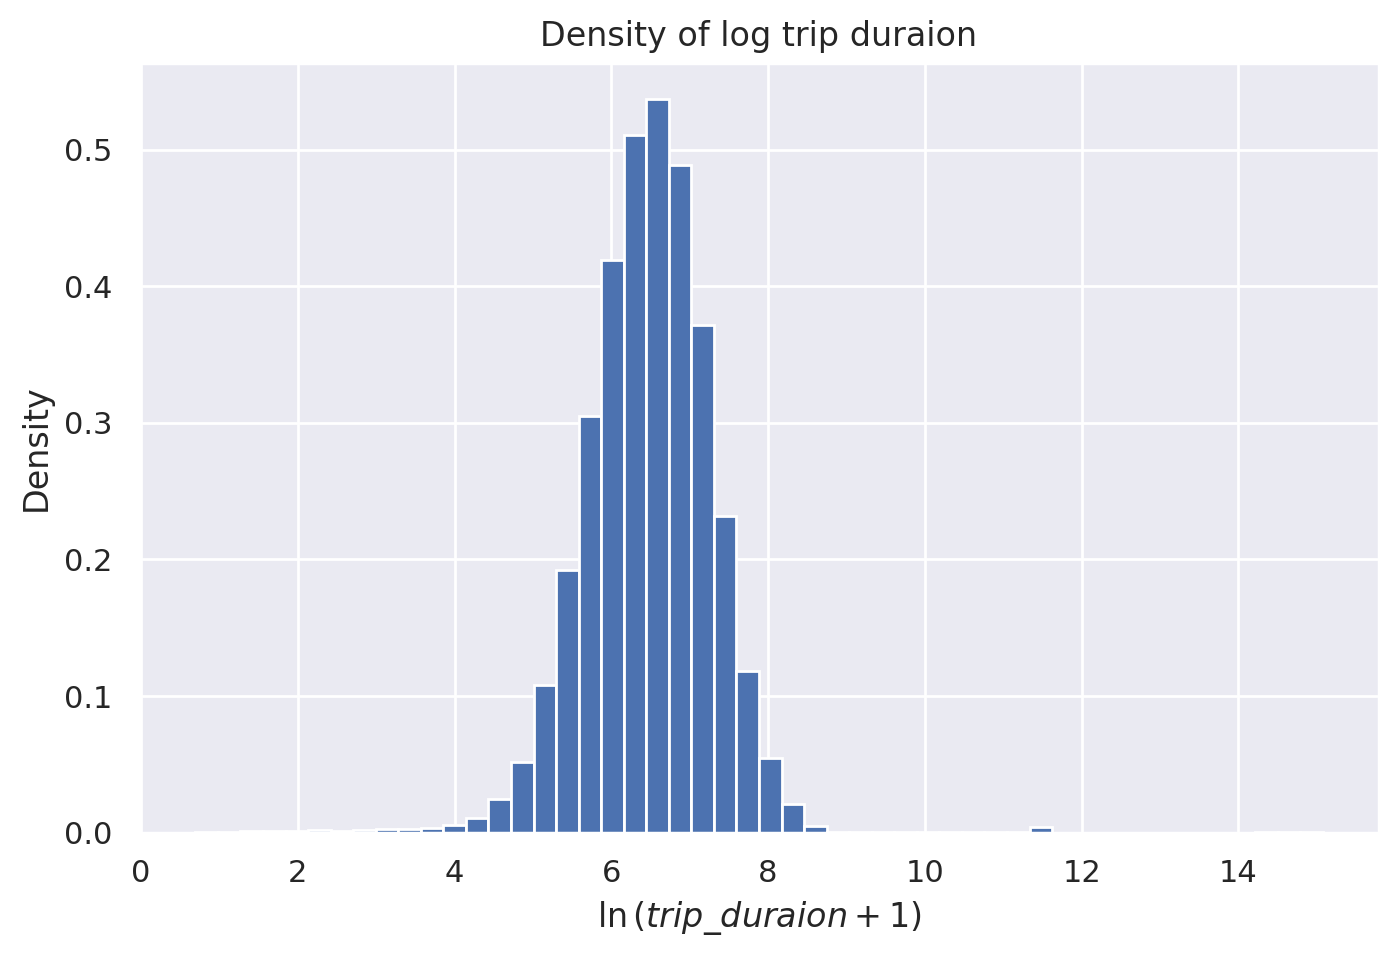

In [101]:
ax = df.hist('log_trip_duration', bins=50, density=True)[0, 0]
ax.set_xlabel('$\ln{(trip\_duraion + 1)}$')
ax.set_ylabel('Density')
ax.set_title('Density of log trip duraion')
plt.show()

In [102]:
df = df.drop(columns=['trip_duration'])

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [103]:
def rmsle(log1p_y_true, log1p_y_pred):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))

rmsle_best_const = rmsle(df['log_trip_duration'], np.mean(df['log_trip_duration']))
print("Best const RMSLE:", rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

Best const RMSLE: 0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [104]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df = df.sort_values("pickup_datetime")
df['date'] = df["pickup_datetime"].dt.strftime('%B %d')

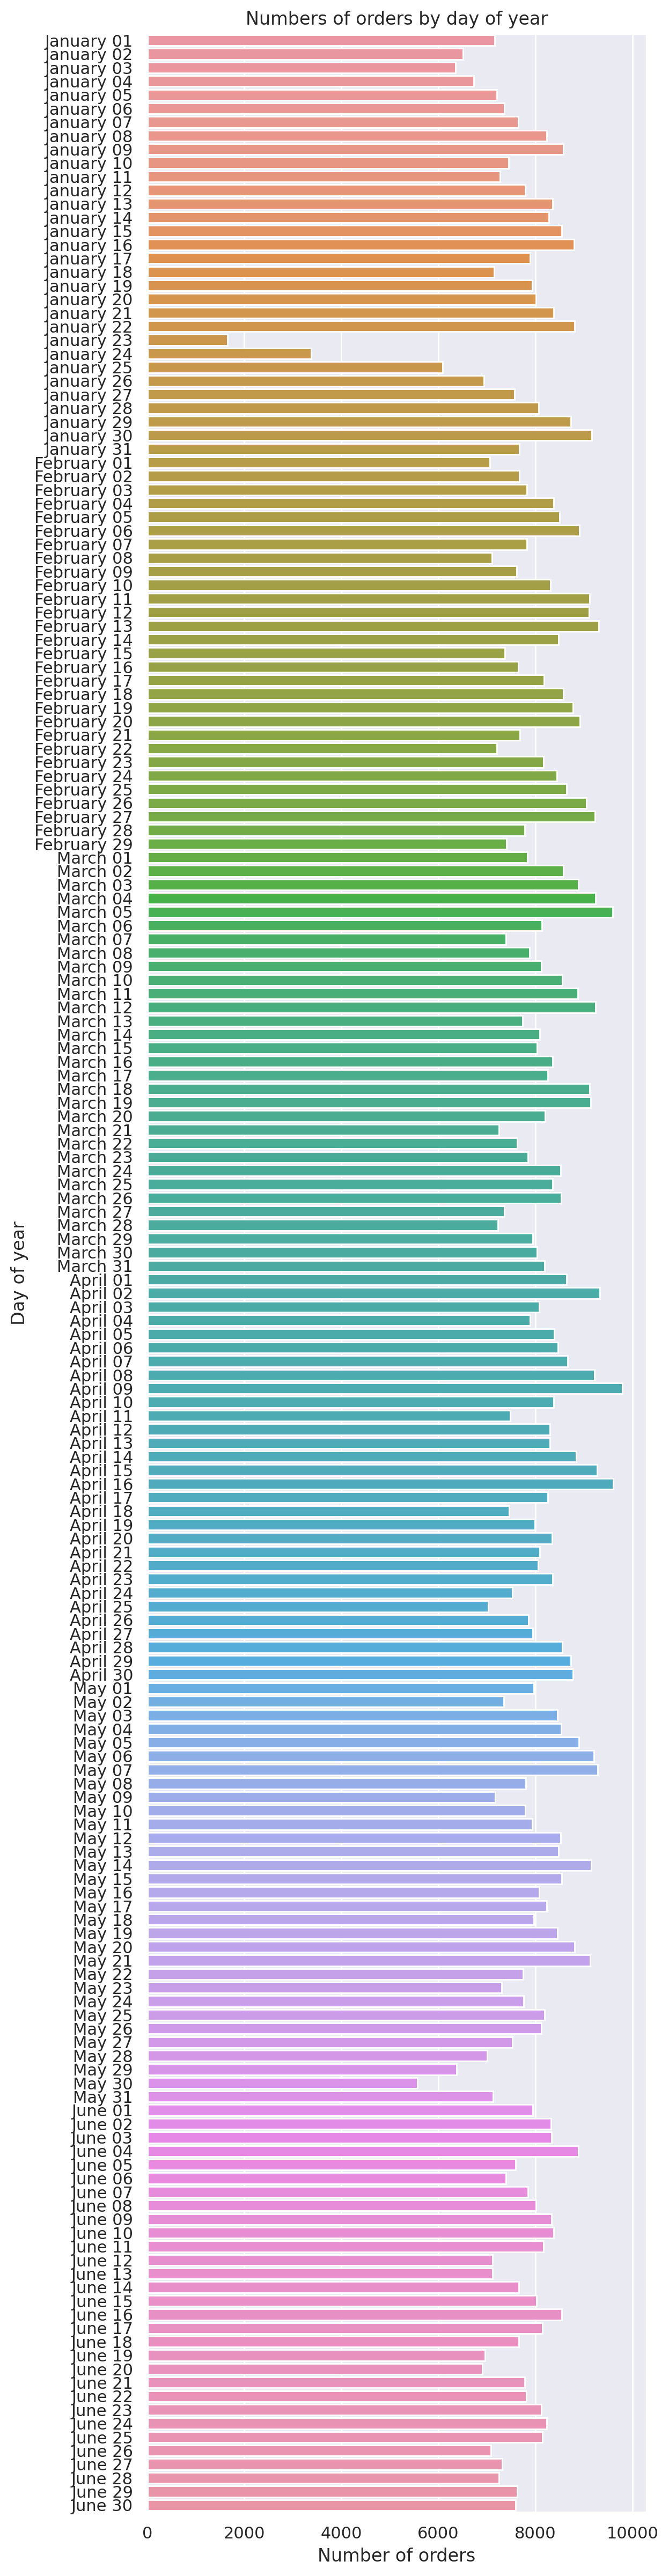

In [105]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
fig, ax = plt.subplots(1, 1, figsize=(6, 30))

ax = sns.countplot(y='date', data=df)
ax.set_xlabel('Number of orders')
ax.set_ylabel('Day of year')
ax.set_title('Numbers of orders by day of year')
fig.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [106]:
temp_df = df.groupby(df["pickup_datetime"].dt.strftime('%m-%d')).count()

In [107]:
abnormal_days = set(temp_df[temp_df['id'] < 6000]['pickup_datetime'].index)

In [108]:
abnormal_days

{'01-23', '01-24', '05-30'}

Январь - [шторм](https://en.wikipedia.org/wiki/January_2016_United_States_blizzard), май - [день памяти](https://www.weather.gov/okx/storm05302016)

In [109]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['weekday'] = df["pickup_datetime"].dt.strftime('%w') + ' ' + df["pickup_datetime"].dt.strftime('%A')
df['hour'] = df["pickup_datetime"].dt.strftime('%H')
df['month'] = df['pickup_datetime'].dt.strftime('%m') + ' ' + df["pickup_datetime"].dt.strftime('%B')

In [ ]:
facet = sns.relplot(
    data=df.groupby(['weekday', 'hour']).count(), x="hour", y="id",
    col='weekday', kind="line", aspect=1.5, facet_kws={'sharey': False, 'sharex': False}
)
facet.set_xlabels('Hour')
facet.set_ylabels('Number of orders')
facet.set_titles('Average number of orders on {col_name}')

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
facet = sns.relplot(
    data=df.groupby(['month', 'hour']).count(), x="hour", y="id",
    hue="month", style="month", kind="line", aspect=2
)
facet.set_xlabels('Hour')
facet.set_ylabels('Number')
plt.title('Average number of orders by month on one plot')

In [ ]:
facet = sns.relplot(
    data=df.groupby(['weekday', 'hour']).count(), x="hour", y="id",
    hue="weekday", style="weekday", kind="line", aspect=2
)
facet.set_xlabels('Hour')
facet.set_ylabels('Number')
plt.title('Average number of orders by weekday on one plot')

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Время с 11 до 5 утра выделяется уменьшением кол-ва поездок (ночью люди спят, дороги пустые), время с 5 до 8 и с 16 до 20 - повышением кол-ва поездок (всем надо на работу/с работы, дороги нагружаются);

Дни - выделяются суббота и воскресенье распределением времени поездки по часам (больше поездок вечером/ночью (на тусовки, т.к. пьяным за руль после нее лучше не садиться) и очень медленный рост времени поездок до обеда (откисон));

Месяцы - распределения кол-ва поездок выглядит примерно одинаково, месяцы не **сильно** выделяются


**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
y = df['log_trip_duration']
x = df.drop(columns='log_trip_duration')
x['daynum'] = x['pickup_datetime'].dt.strftime('%j')
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [ ]:
facet = sns.relplot(
    data=df[df['id'].isin(x_train['id'])].groupby(['weekday']).mean(),
    x="weekday",
    y="log_trip_duration",
    kind="line",
    aspect=1.5
)
plt.xlabel('Weekday')
plt.ylabel('Log-Trip duration')
plt.title('Average log duration of trip by weekday')

In [ ]:
sns.relplot(
    data=df[df['id'].isin(x_train['id'])].groupby(['hour']).mean(),
    x="hour",
    y="log_trip_duration",
    kind="line",
    aspect=1.5
)
plt.xlabel('Hour')
plt.ylabel('Log-Trip duration')
plt.title('Average log duration of trip by hour')

<ipython-input-119-acd9edd1a3ad>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data=df[df['id'].isin(x_train['id'])].groupby([df['pickup_datetime'].dt.day_of_year]).mean(),


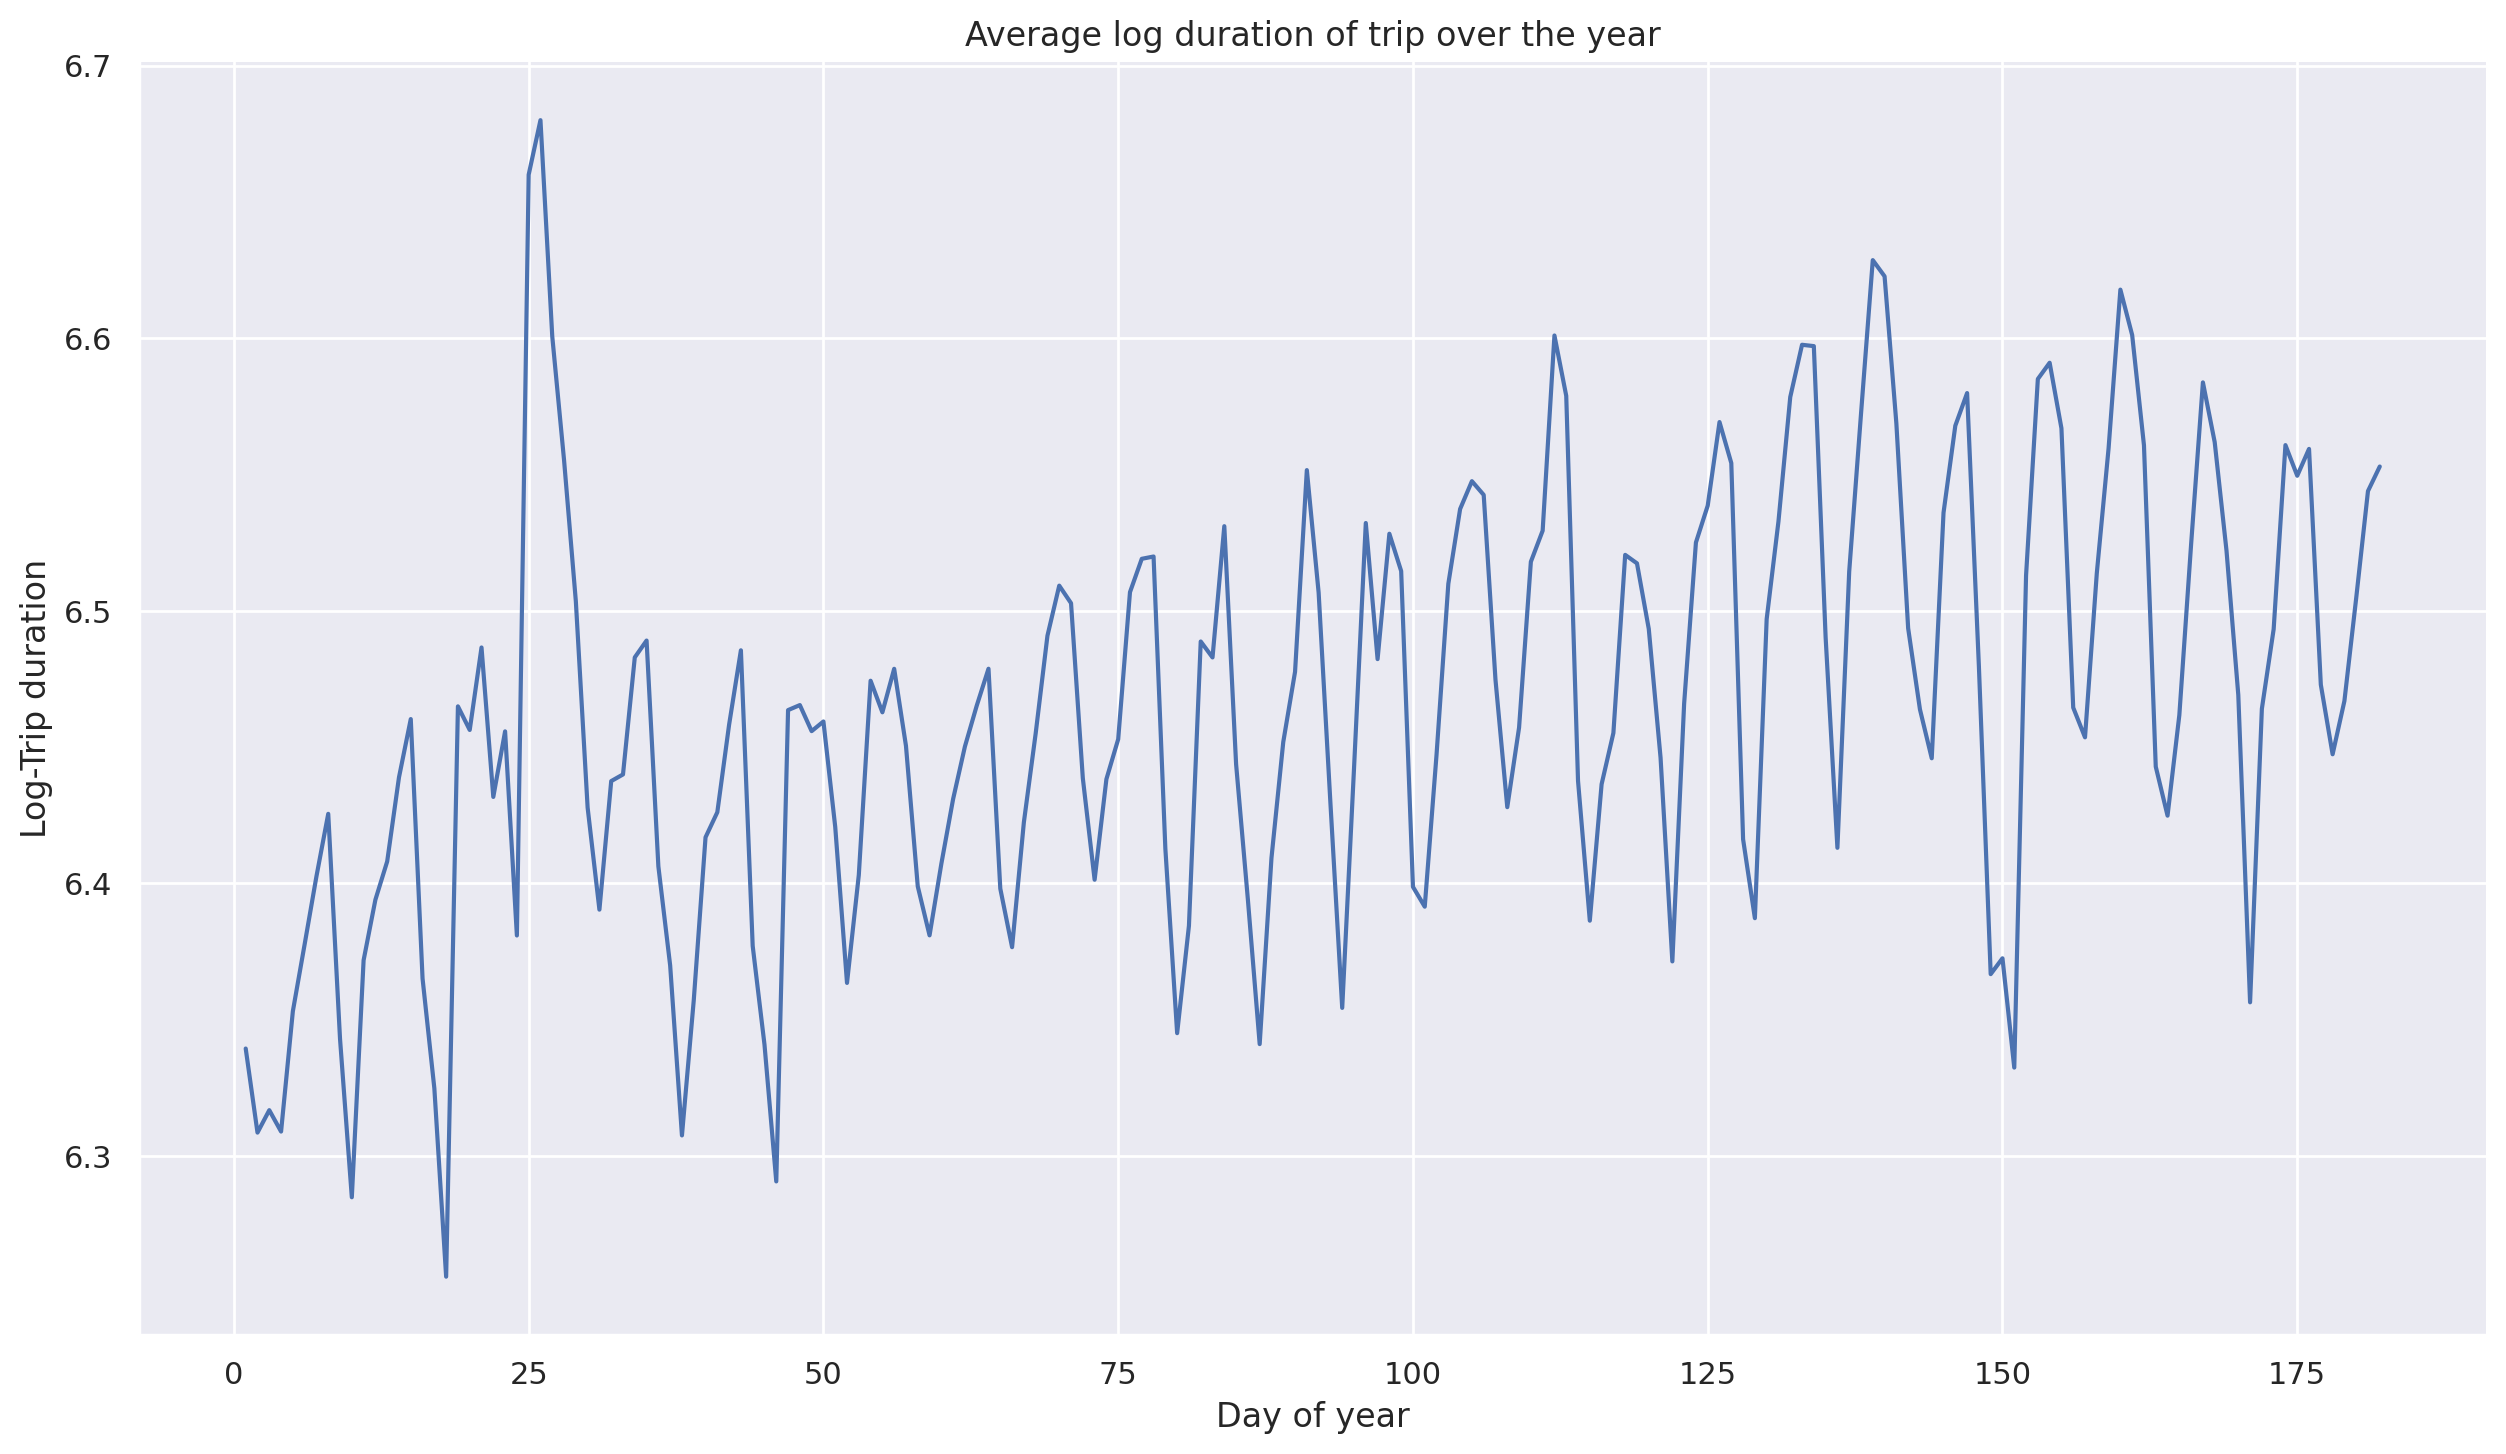

In [119]:
ax = sns.relplot(
    data=df[df['id'].isin(x_train['id'])].groupby([df['pickup_datetime'].dt.day_of_year]).mean(),
    x='pickup_datetime',
    y="log_trip_duration",
    kind="line",
    height=10
)
plt.xlabel('Day of year')
plt.ylabel('Log-Trip duration')
plt.title('Average log duration of trip over the year')
ax.figure.set_size_inches(13, 7)
plt.show()

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Графики зависимости таргета от дня в недели и от часа в сутках похожи на аналогичные графики для кол-ва поездок, потому что загруженность на дорогах вызывает более долгое время поездки, а загруженность на дорогах вызывает в том числе спрос на такси

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
def add_features_first_round(df: pd.DataFrame) -> pd.DataFrame:
    df['is_abnormal_1'] = 0
    df['is_abnormal_2'] = 0
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '01-23', 'is_abnormal_1'] = 1
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '01-24', 'is_abnormal_1'] = 1
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '05-30', 'is_abnormal_2'] = 1
    df['daynum'] = df['pickup_datetime'].dt.strftime('%j')
    df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
    return df.drop(columns=['id', 'vendor_id', 'pickup_datetime', 'passenger_count',
                     'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                     'dropoff_latitude', 'store_and_fwd_flag'])

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

В качестве категориальных разумно брать всё, кроме дня в году, т.к. нет никакой линейной зависимости между ними и таргетом, а в графике день года/логарифм поездки виден какой-никакой, но линейный тренд

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [ ]:
numeric = ['daynum']
categorical = ['hour', 'month', 'weekday', 'is_abnormal_1', 'is_abnormal_2']

column_transformer_1st_round = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_1st_round = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_1st_round),
    ('regression', Ridge())
])

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
x_train_1st = add_features_first_round(x_train)
x_test_1st = add_features_first_round(x_test)
model = pipeline_1st_round.fit(x_train_1st, y_train)

In [125]:
print("RMSLE after 1st round of features:", rmsle(y_test, model.predict(x_test_1st)))

RMSLE after 1st round of features: 0.791497713605711


In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

1) Манхэттен
2) Аэропорт им. Кеннеди
3) Аэропорт Ла Гуардия

В первом больше всего заказов, 2-3 важны, потому что дорога в аэропорт/из аэропорта априори особенная и занимает много времени

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
df_train = df[df['id'].isin(x_train['id'])]
df_test = df[df['id'].isin(x_test['id'])]
df_train['hour_int'] = pd.to_numeric(df_train['hour'])
df_train['weekday_num'] = df_train["pickup_datetime"].dt.strftime('%w')

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

df_train['haversine'] = haversine_array(df_train['pickup_latitude'], df_train['pickup_longitude'],
                                        df_train['dropoff_latitude'], df_train['dropoff_longitude'])

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['log_haversine'] = np.log1p(df_train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
your_df = df_train
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
ax = (np.exp(df_train['log_haversine'] - df_train['log_trip_duration'])).hist(bins=200)
ax.set_xlabel('Log Speed')
ax.set_ylabel('Number of samples')
ax.set_title('Distribution of average taxi speed')

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

Text(0.5, 1.0, 'Distribution of average taxi speed without outliers')

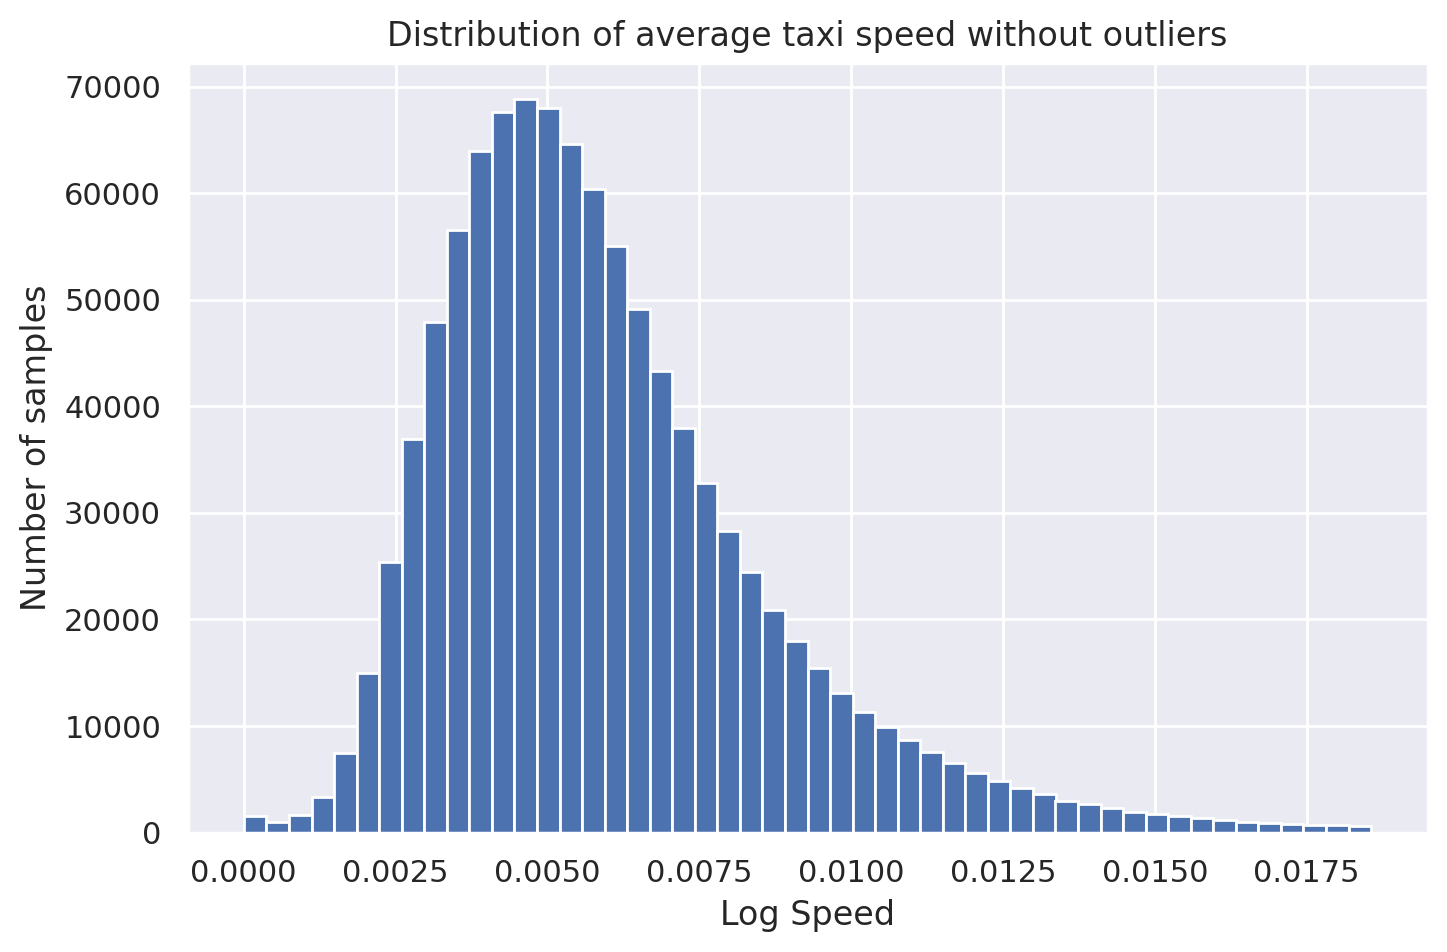

In [135]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
speed = (np.exp(df_train['log_haversine'] - df_train['log_trip_duration']))
ax = plt.hist(speed[speed <= speed.quantile(0.99)], bins=50)[2]
plt.xlabel('Log Speed')
plt.ylabel('Number of samples')
plt.title('Distribution of average taxi speed without outliers')

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<ipython-input-144-cf842fff766c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['speed'] = (np.exp(df_train['log_haversine'] - df_train['log_trip_duration']))
<ipython-input-144-cf842fff766c>:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  sns.heatmap(df_train.groupby(['weekday', 'hour']).median().reset_index().pivot("weekday", "hour", "speed"),
<ipython-input-144-cf842fff766c>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  sns.heatmap(df_train.groupby(['weekday', 'hour']).median().rese

Text(0.5, 1.0, 'Heatmap of median of speed by weekday/hour')

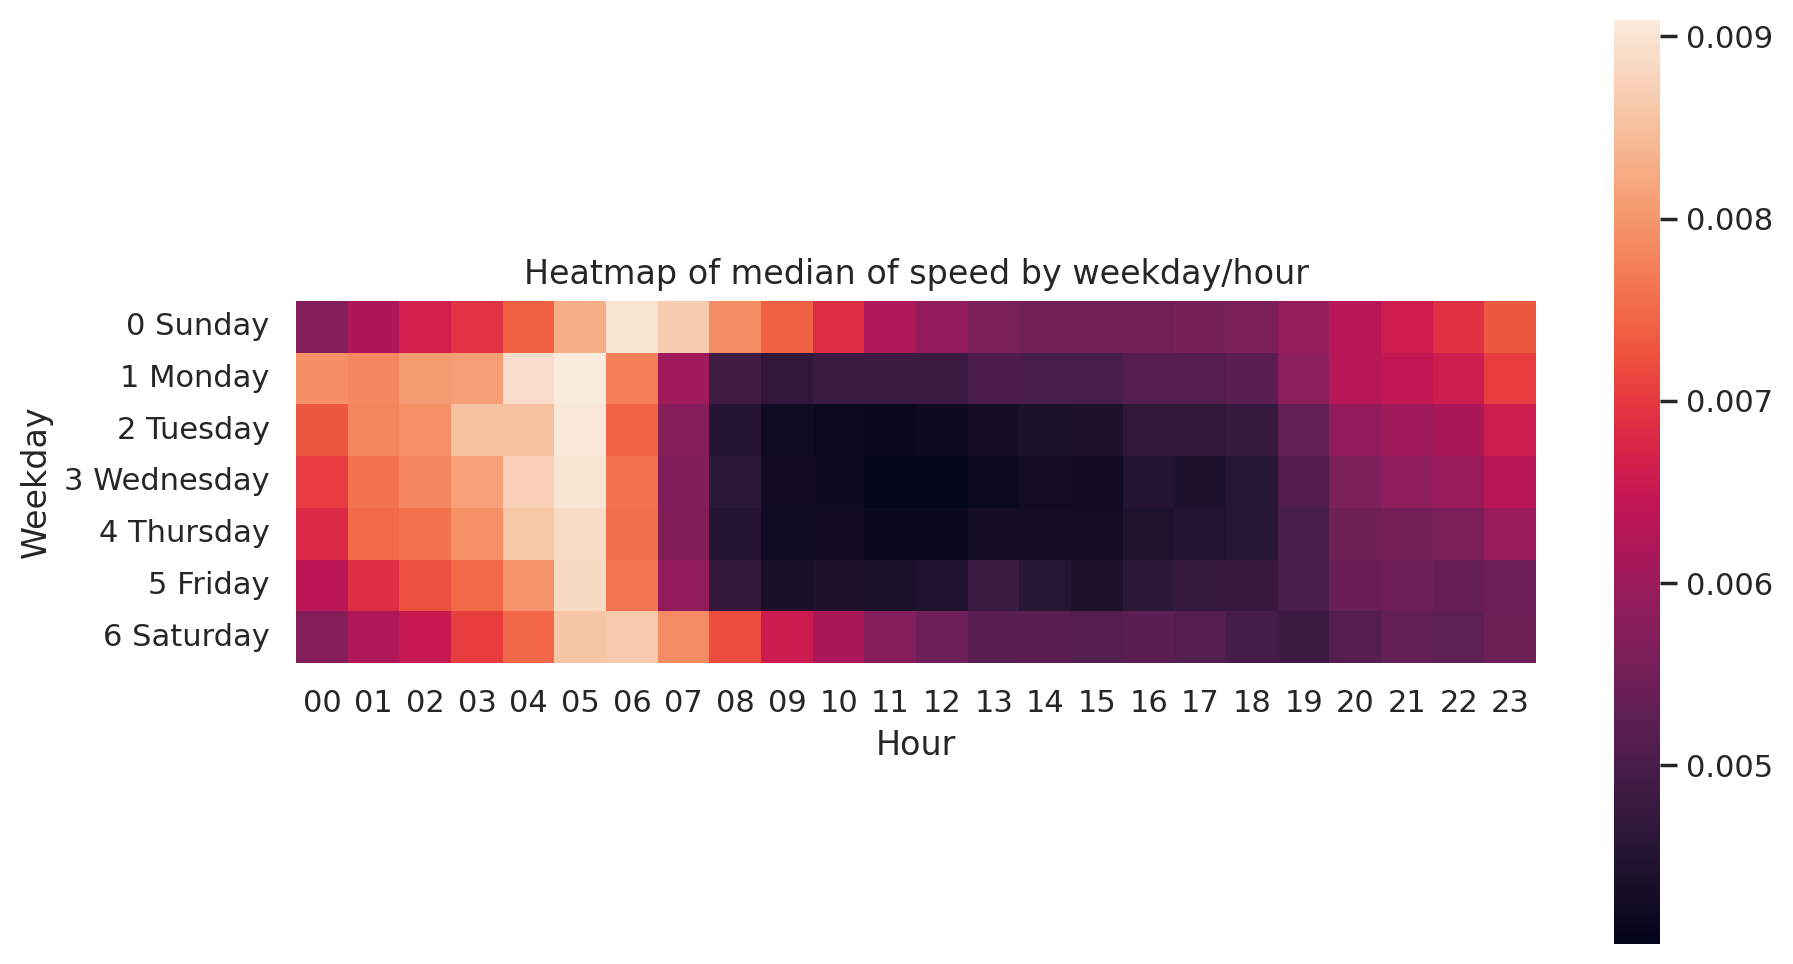

In [144]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['speed'] = (np.exp(df_train['log_haversine'] - df_train['log_trip_duration']))
sns.heatmap(df_train.groupby(['weekday', 'hour']).median().reset_index().pivot("weekday", "hour", "speed"),
            square=True)
plt.xlabel('Hour')
plt.ylabel('Weekday')
plt.title('Heatmap of median of speed by weekday/hour')

Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

утечка таргета

In [145]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train = df_train.drop(columns=['speed'])

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [146]:
df_train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
log_trip_duration            float64
date                          object
weekday                       object
hour                          object
month                         object
hour_int                       int64
weekday_num                   object
haversine                    float64
log_haversine                float64
dtype: object

In [147]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train['rush_hour'] = 0
df_train.loc[(df_train['weekday_num'].isin(map(str, range(1, 6)))) & (7 <= df_train['hour_int']) & (df_train['hour_int'] <= 18), 'rush_hour'] = 1
df_train['clear_roads'] = 0
df_train.loc[(df_train['weekday_num'].isin(map(str, range(1, 6)))) & (1 <= df_train['hour_int']) & (df_train['hour_int'] <= 5) |
             ~(df_train['weekday_num'].isin(map(str, range(1, 6)))) & (2 <= df_train['hour_int']) & (df_train['hour_int'] <= 9), 'clear_roads'] = 1

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [148]:
df_train[df_train['rush_hour'] == 1]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,date,weekday,hour,month,hour_int,weekday_num,haversine,log_haversine,rush_hour,clear_roads
355993,id0316889,2,2016-01-01 07:00:10,1,-73.990723,40.740101,-73.980698,40.648949,N,7.104144,January 01,5 Friday,07,01 January,7,5,10.170839,2.413307,1,0
1152624,id2723874,1,2016-01-01 07:00:19,1,-74.011261,40.711063,-73.992355,40.749687,N,6.870053,January 01,5 Friday,07,01 January,7,5,4.580700,1.719314,1,0
7149,id0669850,2,2016-01-01 07:00:36,1,-73.976227,40.751530,-73.998871,40.760326,N,5.713733,January 01,5 Friday,07,01 January,7,5,2.143498,1.145336,1,0
727287,id3086565,1,2016-01-01 07:00:46,1,-73.912308,40.744396,-73.919067,40.758789,N,5.932245,January 01,5 Friday,07,01 January,7,5,1.698687,0.992765,1,0
808030,id2792716,1,2016-01-01 07:01:09,3,-73.953766,40.787888,-73.934608,40.797367,N,5.857933,January 01,5 Friday,07,01 January,7,5,1.926652,1.073859,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257244,id1098977,1,2016-06-30 18:59:13,1,-73.972878,40.692768,-73.995247,40.695141,N,6.470800,June 30,4 Thursday,18,06 June,18,4,1.904291,1.066189,1,0
591551,id3679224,2,2016-06-30 18:59:13,5,-73.951981,40.777748,-73.956581,40.766800,N,5.968708,June 30,4 Thursday,18,06 June,18,4,1.277538,0.823095,1,0
1085846,id1127392,1,2016-06-30 18:59:19,1,-73.994873,40.744823,-73.984016,40.749378,N,5.552960,June 30,4 Thursday,18,06 June,18,4,1.045443,0.715615,1,0
1068065,id0844695,2,2016-06-30 18:59:29,1,-73.965530,40.762878,-73.942352,40.786331,N,6.285998,June 30,4 Thursday,18,06 June,18,4,3.257308,1.448637,1,0


Заметили 2 особых точки начала/конца поездки - аэропорты им. Кеннеди (международный) и Лагуардиа (внутренние рейсы)

In [149]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
jfk_coords = [40.641766, -73.780968]
laguardia_coords = [40.7769271, -73.8739659]
df_train['from_airport'] = 0
df_train.loc[haversine_array(df_train['pickup_latitude'], df_train['pickup_longitude'], *jfk_coords) <= 1, 'from_airport'] = 1
df_train.loc[haversine_array(df_train['pickup_latitude'], df_train['pickup_longitude'], *laguardia_coords) <= 1, 'from_airport'] = 1
df_train['to_airport'] = 0
df_train.loc[haversine_array(df_train['dropoff_latitude'], df_train['dropoff_longitude'], *jfk_coords) <= 1, 'to_airport'] = 1
df_train.loc[haversine_array(df_train['dropoff_latitude'], df_train['dropoff_longitude'], *laguardia_coords) <= 1, 'to_airport'] = 1

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

Text(0.5, 1.0, 'Boxplot of distribution of target based on "rush_hour" feature')

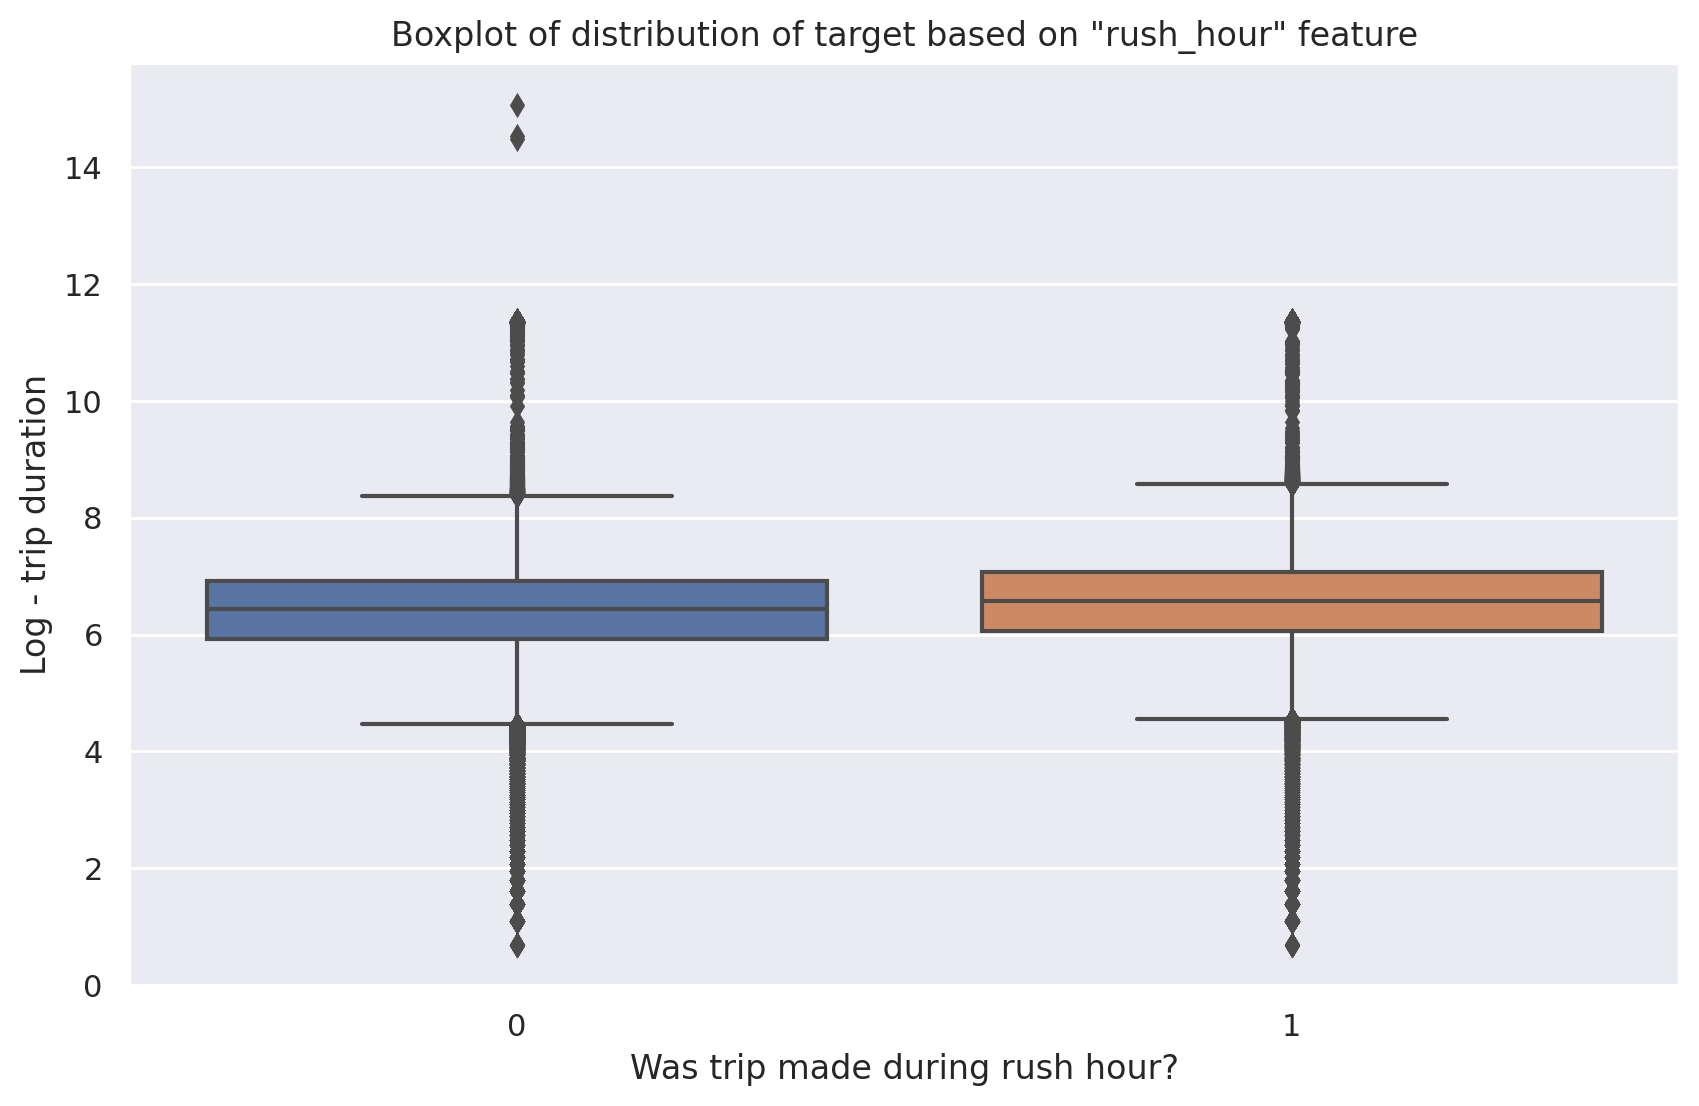

In [151]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
sns.boxplot(df_train, x='rush_hour', y='log_trip_duration')
plt.xlabel('Was the trip made during rush hour?')
plt.ylabel('Log - trip duration')
plt.title('Boxplot of distribution of target based on "rush_hour" feature')

Text(0.5, 1.0, 'Boxplot of distribution of target based on "clear_roads" feature')

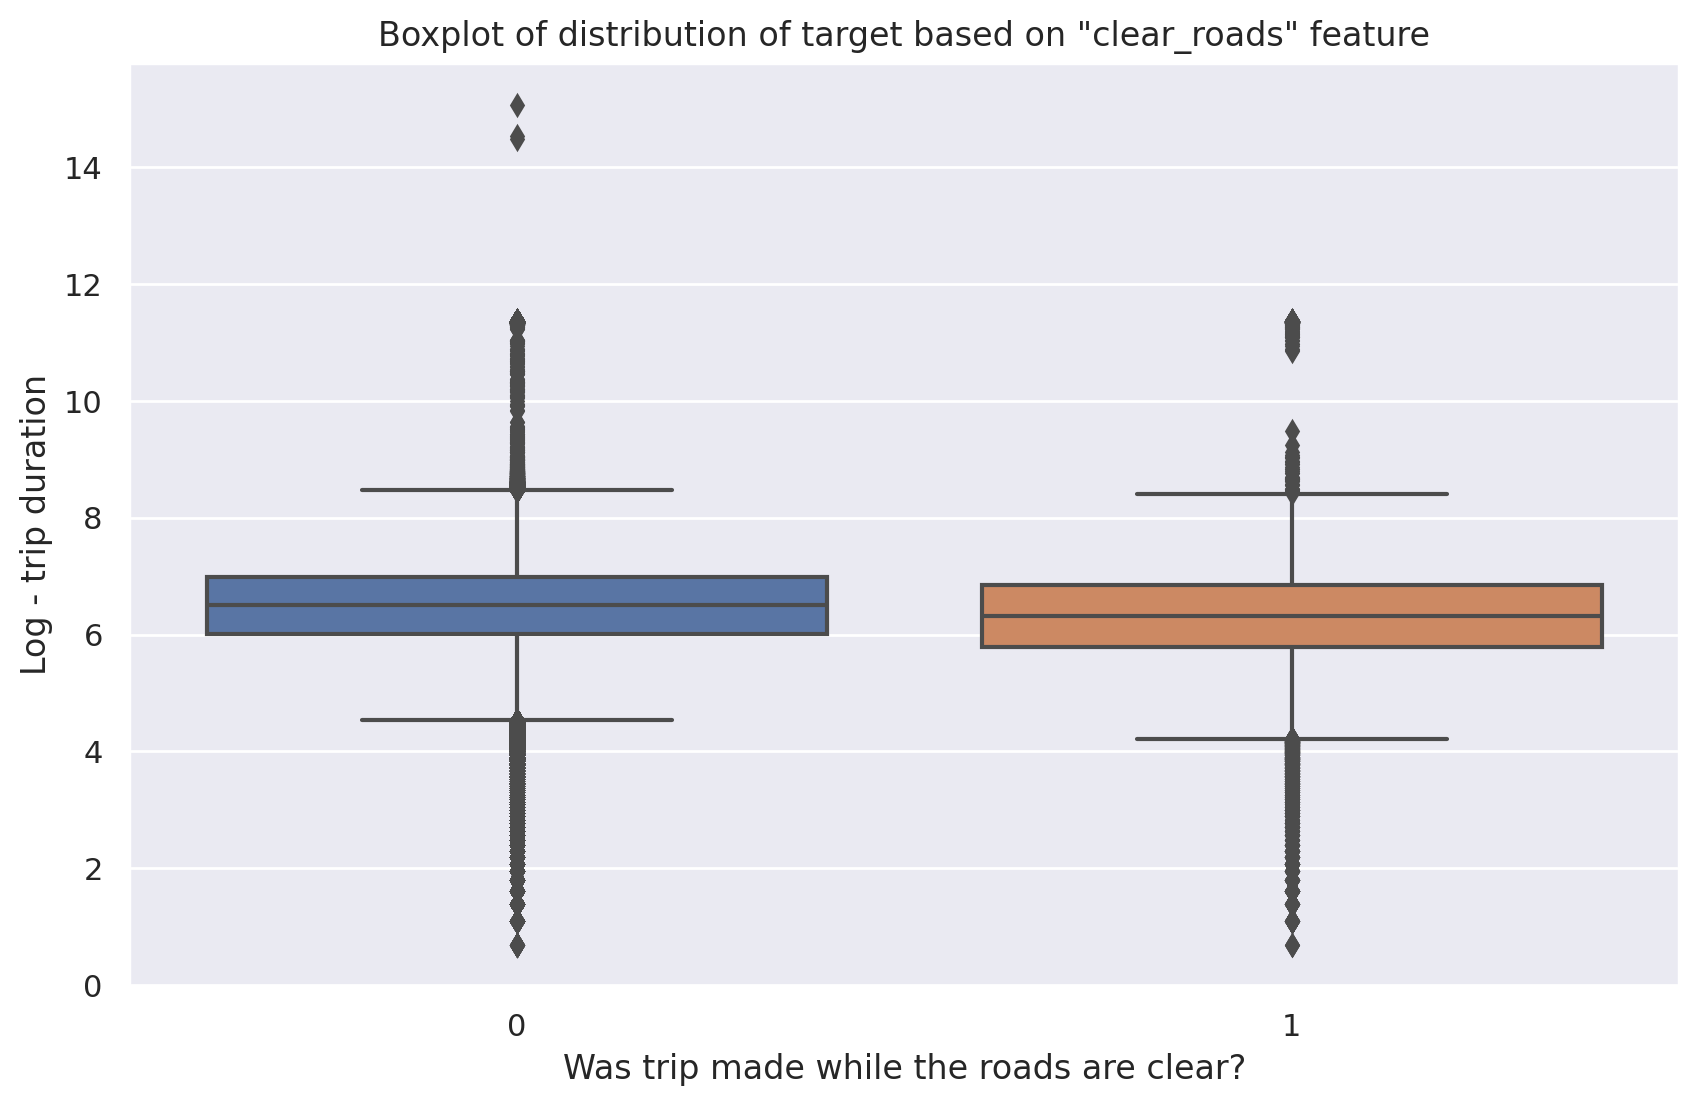

In [152]:
sns.boxplot(df_train, x='clear_roads', y='log_trip_duration')
plt.xlabel('Was the trip made while the roads are clear?')
plt.ylabel('Log - trip duration')
plt.title('Boxplot of distribution of target based on "clear_roads" feature')

Text(0.5, 1.0, 'Boxplot of distribution of target based on "from_airport" feature')

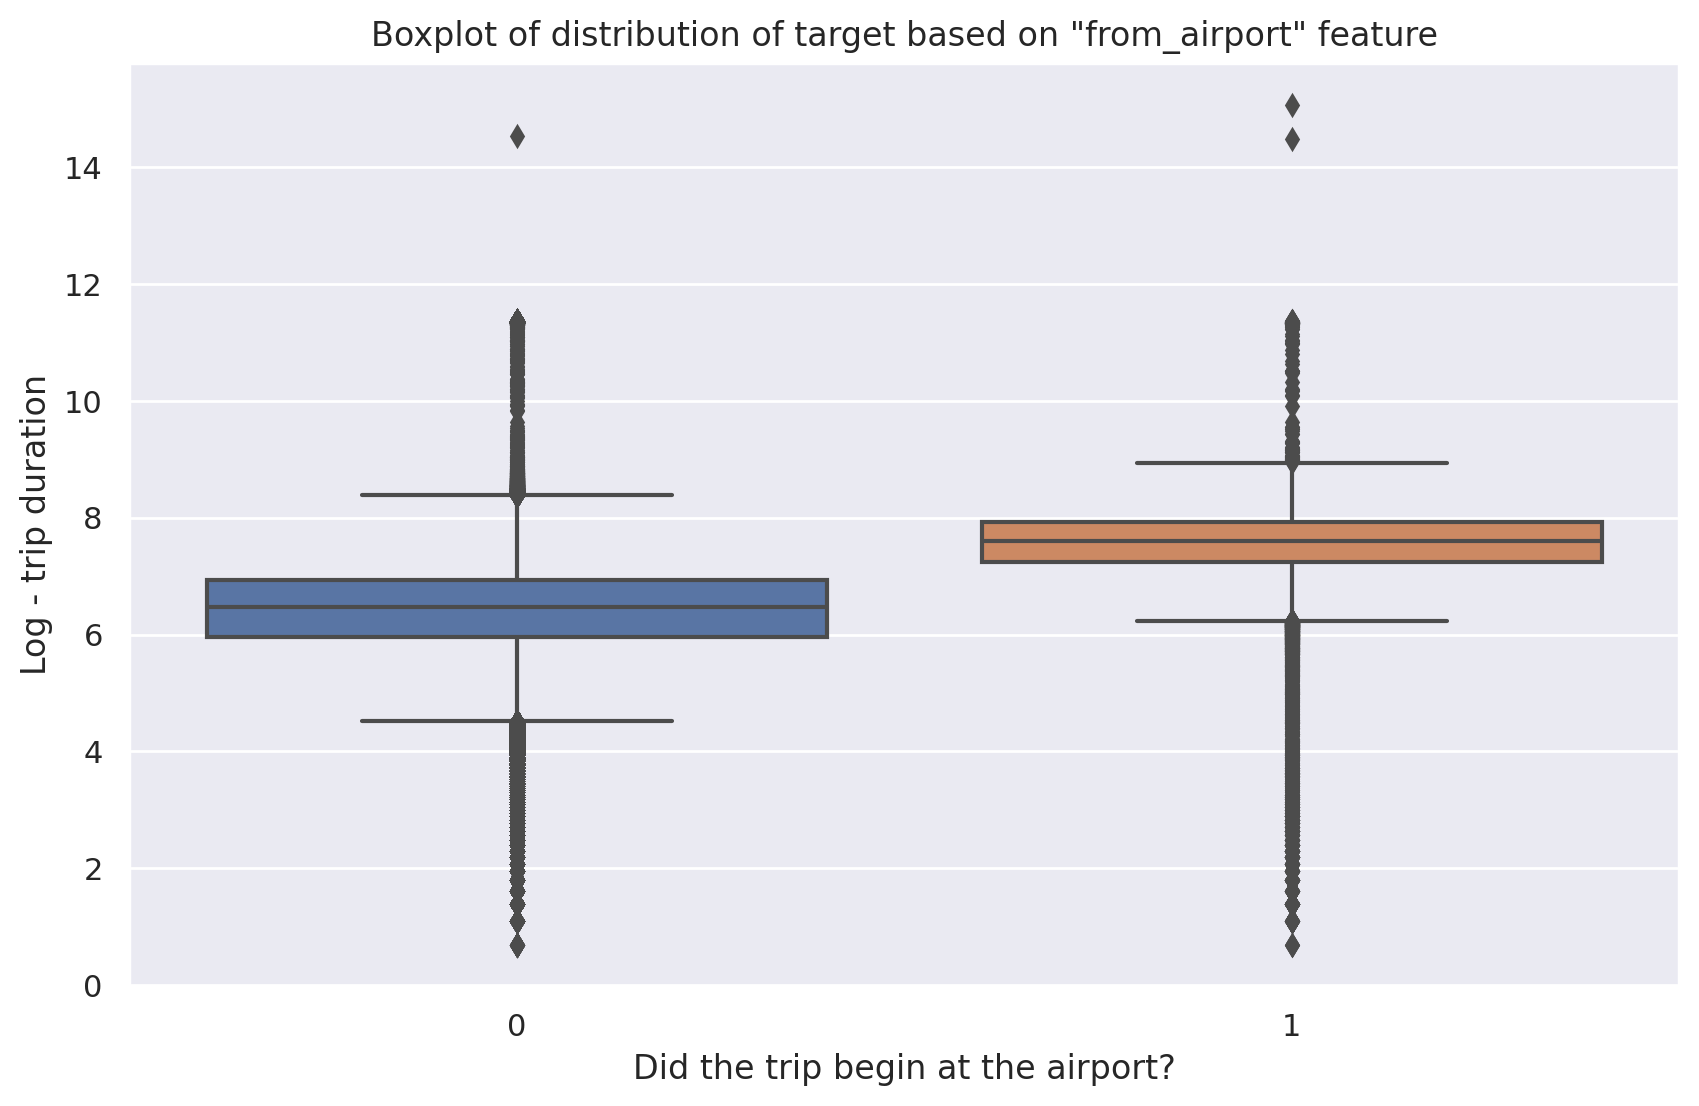

In [153]:
sns.boxplot(df_train, x='from_airport', y='log_trip_duration')
plt.xlabel('Did the trip begin at the airport?')
plt.ylabel('Log - trip duration')
plt.title('Boxplot of distribution of target based on "from_airport" feature')

Text(0.5, 1.0, 'Boxplot of distribution of target based on "to_airport" feature')

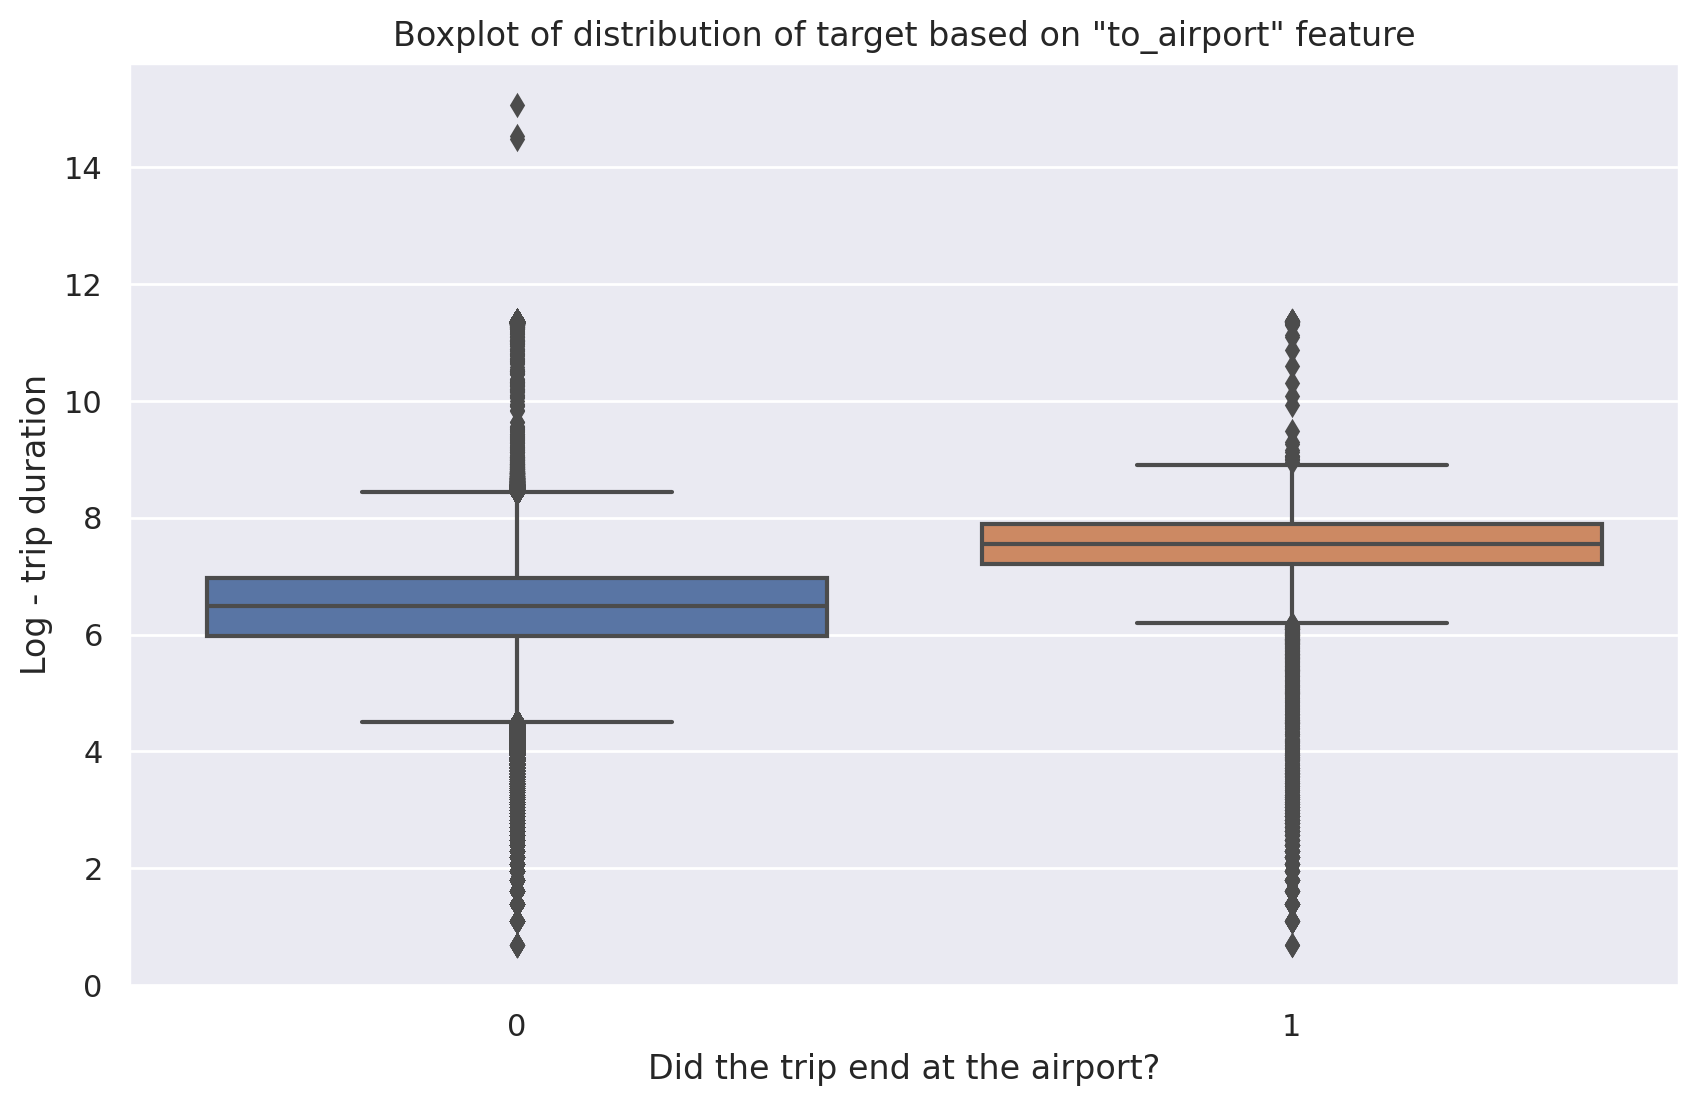

In [154]:
sns.boxplot(df_train, x='to_airport', y='log_trip_duration')
plt.xlabel('Did the trip end at the airport?')
plt.ylabel('Log - trip duration')
plt.title('Boxplot of distribution of target based on "to_airport" feature')

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

rush_hour и clear_roads - не очень хорошие, т.к. распределения таргета при кластеризации объектов по этим признакам выглядят примерно равными, а вот from/to_airport - хороший с этой точки зрения

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [155]:
from sklearn.base import BaseEstimator, TransformerMixin


# TransformerMixin implements fit_transform for you,
# applying your fit and transform consistently

class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, num_rows=15, num_cols=10):
        self.num_rows = num_rows
        self.num_cols = num_cols
        self.left_longitude = None
        self.right_longitude = None
        self.upper_latitude = None
        self.lower_latitude = None
        self.height = None
        self.width = None
        pass

    def show_map(self):
        if (self.right_longitude is not None):
          location = ((self.upper_latitude + self.lower_latitude) / 2, (self.right_longitude + self.left_longitude) / 2)
          m = folium.Map(location=location)
          folium.Rectangle([(self.upper_latitude, self.left_longitude), (self.lower_latitude, self.right_longitude)],
                    color="red",
                    weight=2,
                    fill=True,
                    fill_color="red",
                    fill_opacity=0.5).add_to(m)
          for i in range(1, self.num_rows):
              folium.PolyLine([(self.lower_latitude + i * self.height, self.left_longitude), (self.lower_latitude + i * self.height, self.right_longitude)],
                      color="red",
                      weight=2,
                      fill=True,
                      fill_color="red",
                      fill_opacity=0.5).add_to(m)
          for i in range(1, self.num_cols):
              folium.PolyLine([(self.lower_latitude, self.left_longitude + i * self.width), (self.upper_latitude, self.left_longitude + i * self.width)],
                      color="red",
                      weight=2,
                      fill=True,
                      fill_color="red",
                      fill_opacity=0.5).add_to(m)
        # you may want to visualize cells
        return m

    def fit(self, X=None, y=None):
        if X is None:
            return self
        lower_bound = X[['dropoff_latitude', 'pickup_latitude']].stack().reset_index(drop=True).quantile(0.05)
        upper_bound = X[['dropoff_latitude', 'pickup_latitude']].stack().reset_index(drop=True).quantile(0.95)
        left_bound = X[['dropoff_longitude', 'pickup_longitude']].stack().reset_index(drop=True).quantile(0.05)
        right_bound = X[['dropoff_longitude', 'pickup_longitude']].stack().reset_index(drop=True).quantile(0.95)
        self.left_longitude = left_bound
        self.right_longitude = right_bound
        self.upper_latitude = upper_bound
        self.lower_latitude = lower_bound
        self.height = (upper_bound - lower_bound) / self.num_rows
        self.width = (right_bound - left_bound) / self.num_cols
        return self

    def transform(self, X, y=None):
        # your code here
        X['cell_pickup'] = -1
        X['cell_dropoff'] = -1
        cond_pickup = (X['pickup_latitude'] <= self.upper_latitude) & (X['pickup_latitude'] >= self.lower_latitude) & (X['pickup_longitude'] >= self.left_longitude) & (X['pickup_longitude'] <= self.right_longitude)
        X.loc[cond_pickup, 'cell_pickup'] = (X[cond_pickup]['pickup_latitude'] - self.lower_latitude) // self.height * self.num_cols + (X[cond_pickup]['pickup_longitude'] - self.left_longitude) // self.width
        cond_dropoff = (X['dropoff_latitude'] <= self.upper_latitude) & (X['dropoff_latitude'] >= self.lower_latitude) & (X['dropoff_longitude'] >= self.left_longitude) & (X['dropoff_longitude'] <= self.right_longitude)
        X.loc[cond_dropoff, 'cell_dropoff'] = (X[cond_dropoff]['dropoff_latitude'] - self.lower_latitude) // self.height * self.num_cols + (X[cond_dropoff]['dropoff_longitude'] - self.left_longitude) // self.width
        # print(X.dtypes)
        return X.drop(columns=['pickup_longitude', 'pickup_latitude',
                               'dropoff_longitude', 'dropoff_latitude'])

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [156]:
def add_features_second_round(df: pd.DataFrame) -> pd.DataFrame:
    df['is_abnormal_1'] = 0
    df['is_abnormal_2'] = 0
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '01-23', 'is_abnormal_1'] = 1
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '01-24', 'is_abnormal_1'] = 1
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '05-30', 'is_abnormal_2'] = 1
    df['daynum'] = df['pickup_datetime'].dt.strftime('%j')
    df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
    df['hour_int'] = pd.to_numeric(df['hour'])
    df['weekday_num'] = df["pickup_datetime"].dt.strftime('%w')
    df['log_haversine'] = np.log1p(haversine_array(df['pickup_latitude'],
                                                   df['pickup_longitude'],
                                                   df['dropoff_latitude'],
                                                   df['dropoff_longitude']))
    df['rush_hour'] = 0
    df.loc[(df['weekday_num'].isin(map(str, range(1, 6))))
                 & (7 <= df['hour_int'])
                 & (df['hour_int'] <= 18), 'rush_hour'] = 1
    df['clear_roads'] = 0
    df.loc[(df['weekday_num'].isin(map(str, range(1, 6))))
                 & (1 <= df['hour_int'])
                 & (df['hour_int'] <= 5)
                 | ~(df['weekday_num'].isin(map(str, range(1, 6))))
                     & (2 <= df['hour_int'])
                     & (df['hour_int'] <= 9), 'clear_roads'] = 1
    jfk_coords = [40.641766, -73.780968]
    laguardia_coords = [40.7769271, -73.8739659]
    df['from_airport'] = 0
    df.loc[haversine_array(df['pickup_latitude'],
                           df['pickup_longitude'], *jfk_coords) <= 1,
           'from_airport'] = 1
    df.loc[haversine_array(df['pickup_latitude'],
                           df['pickup_longitude'], *laguardia_coords) <= 1,
           'from_airport'] = 1
    df['to_airport'] = 0
    df.loc[haversine_array(df['dropoff_latitude'],
                           df['dropoff_longitude'], *jfk_coords) <= 1,
           'to_airport'] = 1
    df.loc[haversine_array(df['dropoff_latitude'],
                           df['dropoff_longitude'], *laguardia_coords) <= 1,
           'to_airport'] = 1
    return df.drop(columns=['id', 'vendor_id', 'pickup_datetime',
                            'passenger_count', 'store_and_fwd_flag',
                            'hour_int', 'weekday_num'])

In [157]:
numeric = ['daynum', 'log_haversine']
categorical = ['hour', 'month', 'weekday', 'is_abnormal_1', 'is_abnormal_2',
               'from_airport', 'to_airport', 'rush_hour', 'clear_roads', 'cell_pickup', 'cell_dropoff']
coordinates_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

column_transformer_2nd_round = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_2nd_round = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_2nd_round),
    ('regression', Ridge())
])

In [158]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
transformer_rectangles = MapGridTransformer()
x_train_2nd = transformer_rectangles.fit_transform(add_features_second_round(x_train))
x_test_2nd = transformer_rectangles.transform(add_features_second_round(x_test))

<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])


In [159]:
model = pipeline_2nd_round.fit(x_train_2nd, y_train)

In [160]:
print("RMSLE after 2nd round of features:", rmsle(y_test, model.predict(x_test_2nd)))

RMSLE after 2nd round of features: 0.4739778771215785


In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [161]:
print("vendor_id unique values:", df_train['vendor_id'].unique())
print("passenger_count unique values:", df_train['passenger_count'].unique())
print("store_and_fwd_flag unique values:", df_train['store_and_fwd_flag'].unique())

vendor_id unique values: [2 1]
passenger_count unique values: [5 1 3 4 2 6 8 0 7 9]
store_and_fwd_flag unique values: ['N' 'Y']


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

Text(0.5, 1.0, 'Boxplot of distribution of target based on vendor ID')

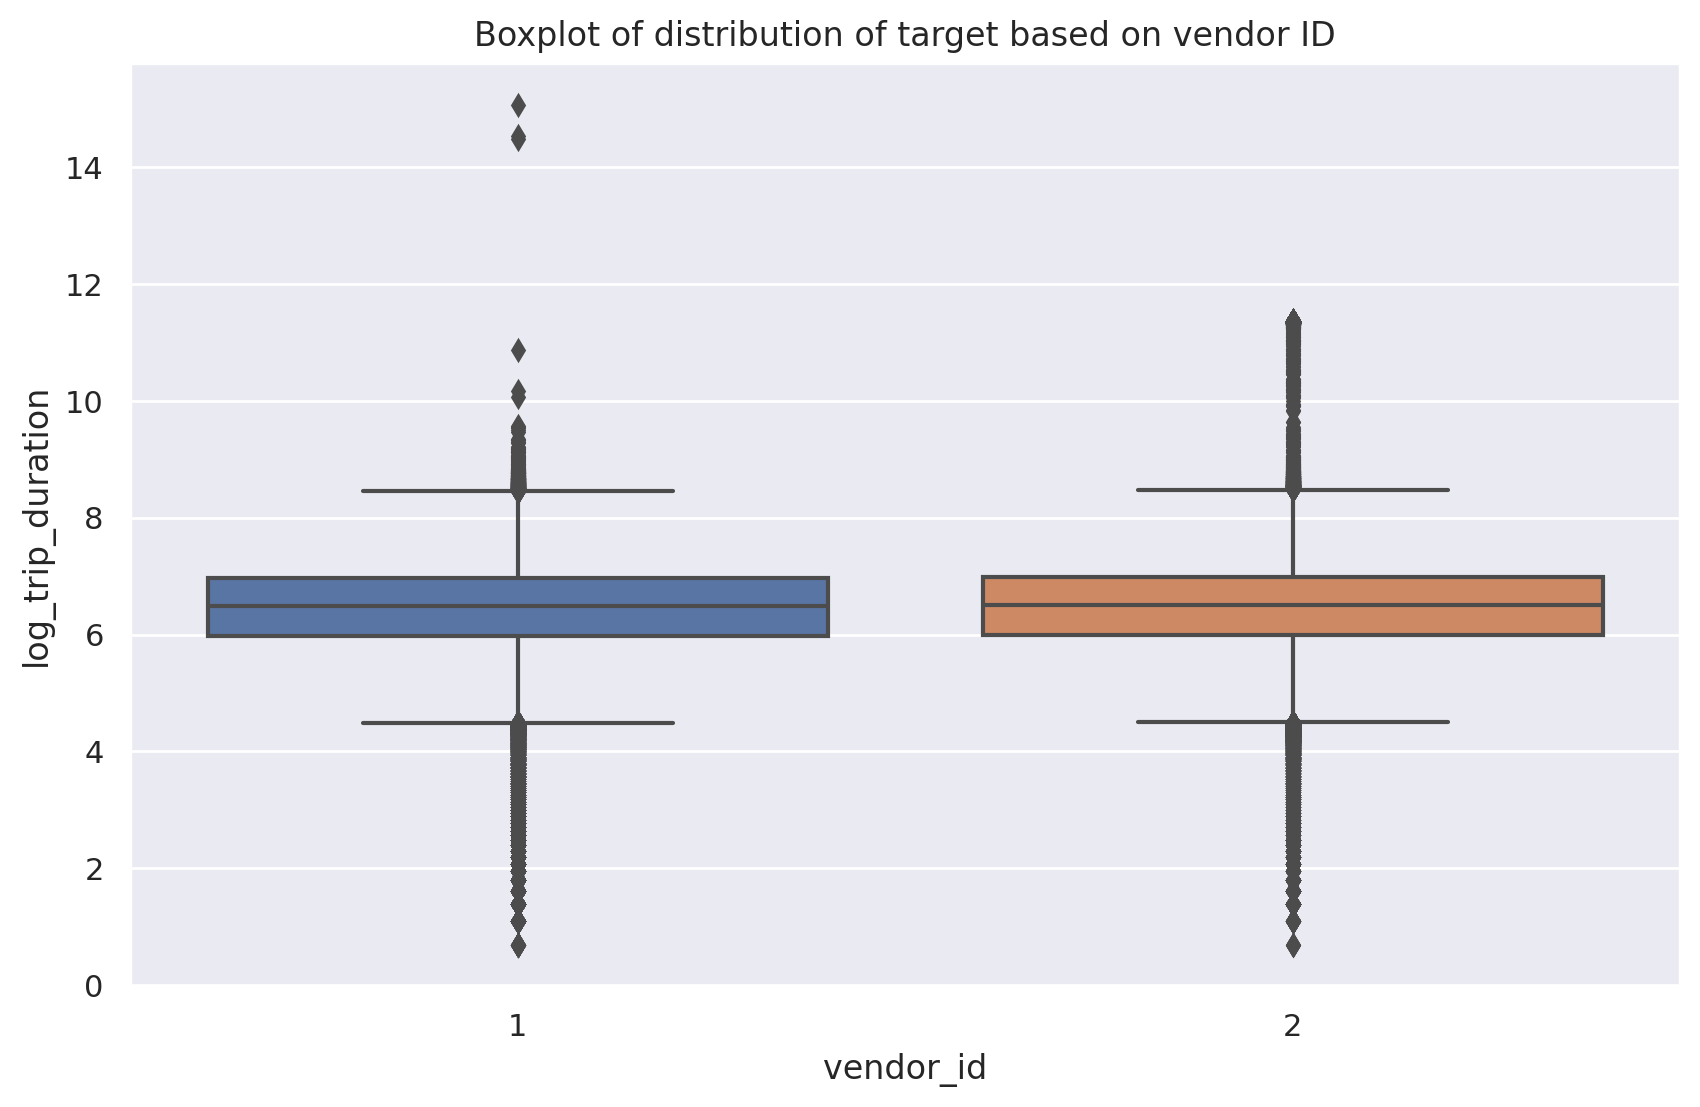

In [162]:
sns.boxplot(df_train, x='vendor_id', y='log_trip_duration')
plt.title('Boxplot of distribution of target based on vendor ID')

Text(0.5, 1.0, 'Boxplot of distribution of target based on passenger count')

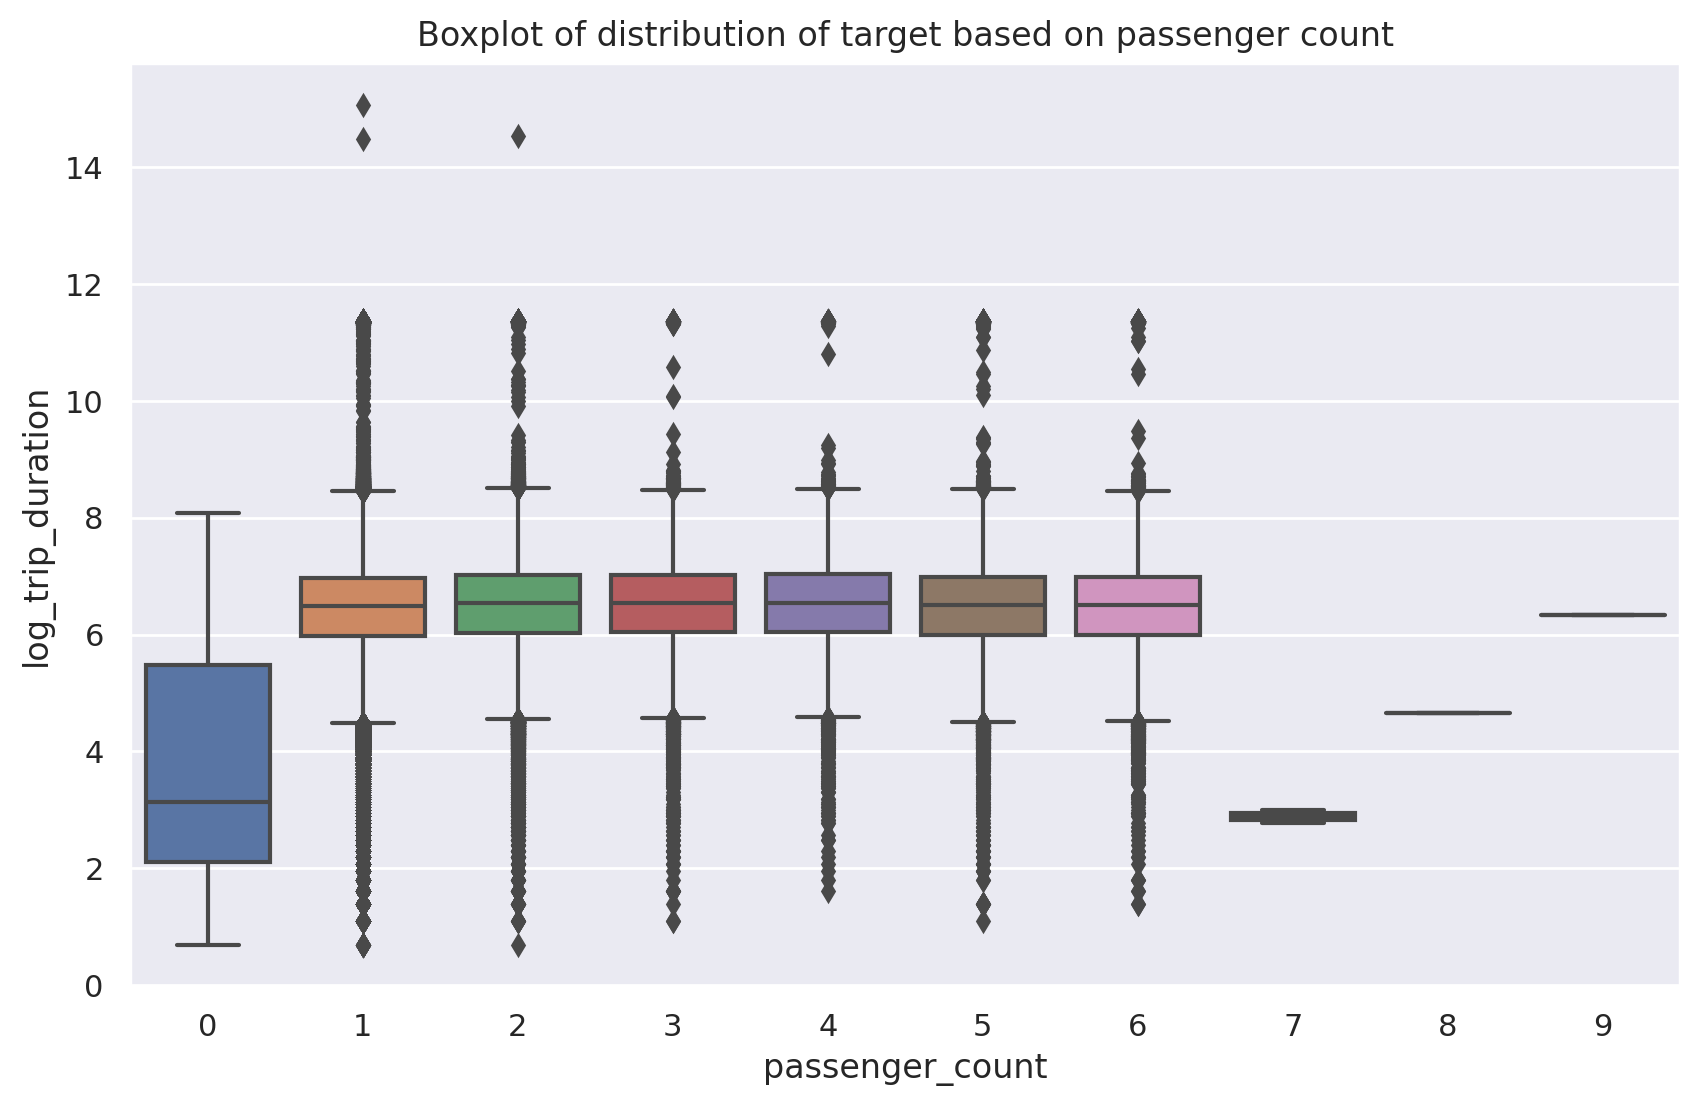

In [163]:
sns.boxplot(df_train, x='passenger_count', y='log_trip_duration')
plt.title('Boxplot of distribution of target based on passenger count')

Text(0.5, 1.0, 'Boxplot of distribution of target based on "store_and_fwd_flag" feature')

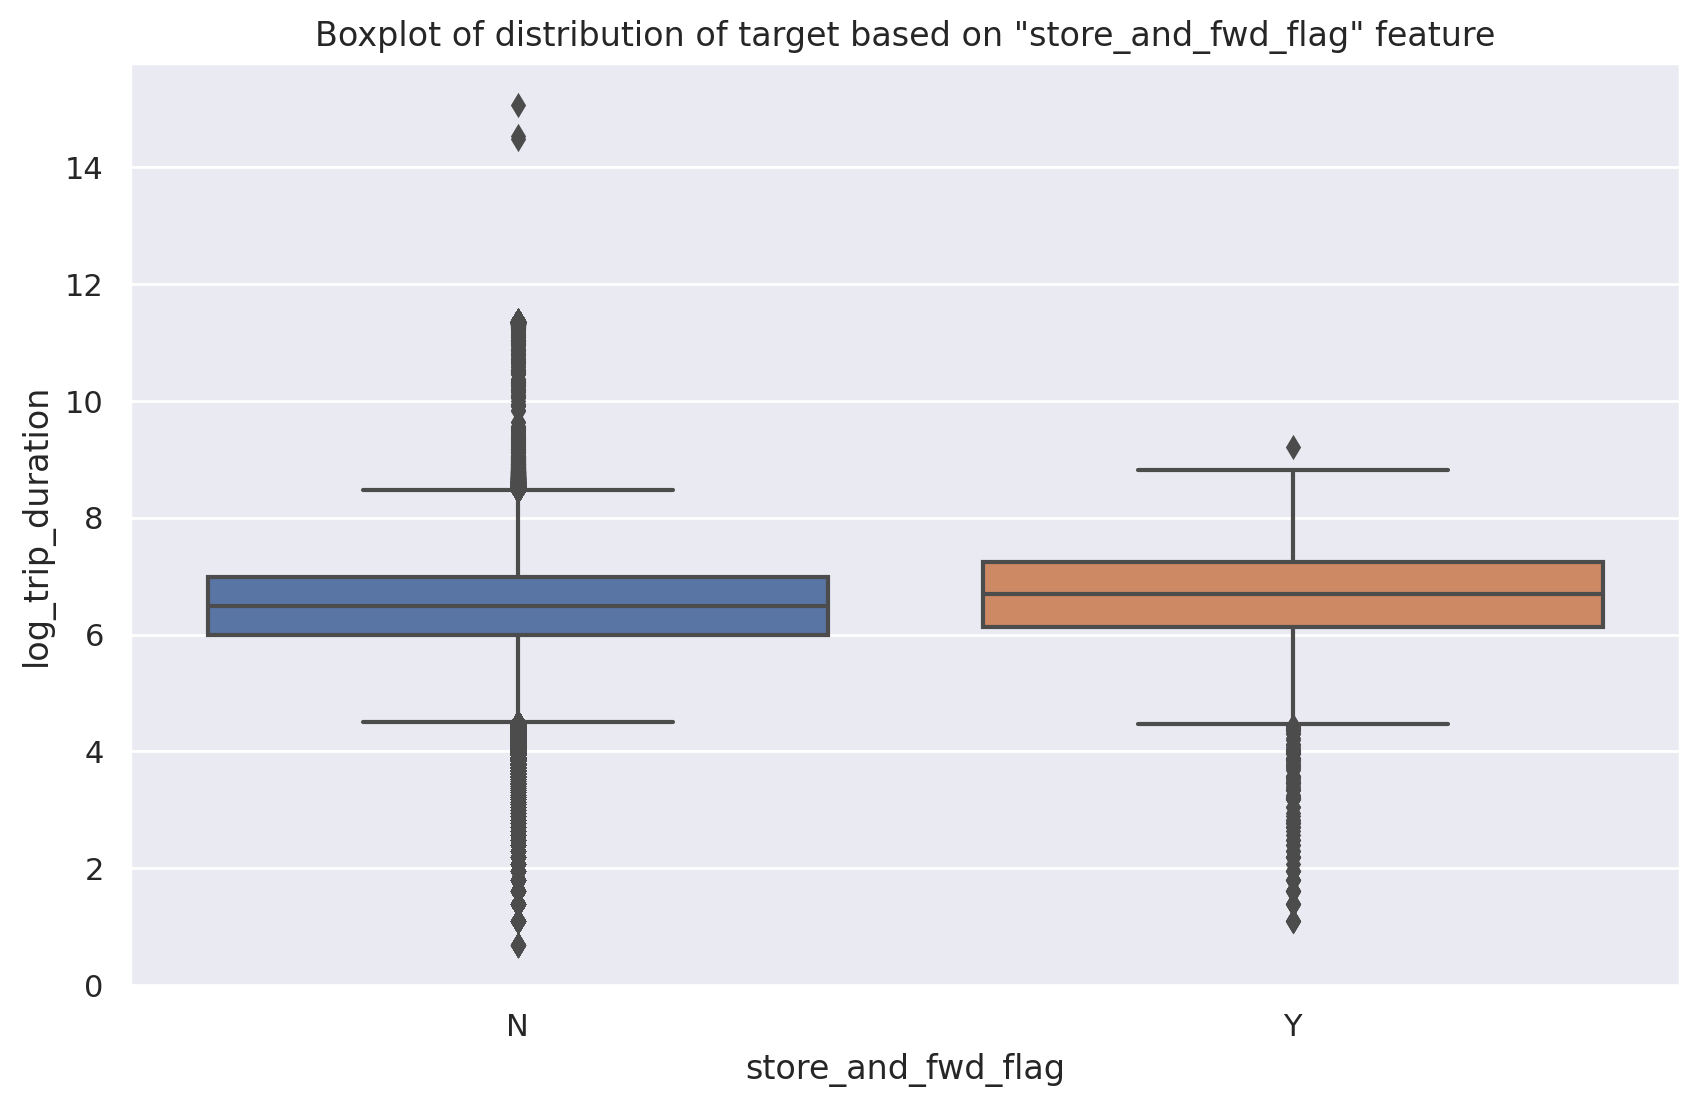

In [164]:
sns.boxplot(df_train, x='store_and_fwd_flag', y='log_trip_duration')
plt.title('Boxplot of distribution of target based on "store_and_fwd_flag" feature')

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [165]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df_train.loc[:, ['vendor_id', 'store_and_fwd_flag']] = df_train[['vendor_id', 'store_and_fwd_flag']].replace({'N': 0, "Y": 1, 2: 0})

<ipython-input-165-fb39e00400a6>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_train.loc[:, ['vendor_id', 'store_and_fwd_flag']] = df_train[['vendor_id', 'store_and_fwd_flag']].replace({'N': 0, "Y": 1, 2: 0})


In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Нет, распределения почти не отличается, кроме passenger_count, где много выборсов с passenger_count = 0 или passenger_count > 6

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [166]:
def add_features_third_round(df: pd.DataFrame) -> pd.DataFrame:
    df['is_abnormal_1'] = 0
    df['is_abnormal_2'] = 0
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '01-23', 'is_abnormal_1'] = 1
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '01-24', 'is_abnormal_1'] = 1
    df.loc[df['pickup_datetime'].dt.strftime('%m-%d') == '05-30', 'is_abnormal_2'] = 1
    df['daynum'] = df['pickup_datetime'].dt.strftime('%j')
    df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
    df['hour_int'] = pd.to_numeric(df['hour'])
    df['weekday_num'] = df["pickup_datetime"].dt.strftime('%w')
    df['log_haversine'] = np.log1p(haversine_array(df['pickup_latitude'],
                                                   df['pickup_longitude'],
                                                   df['dropoff_latitude'],
                                                   df['dropoff_longitude']))
    df['rush_hour'] = 0
    df.loc[(df['weekday_num'].isin(map(str, range(1, 6))))
                 & (7 <= df['hour_int'])
                 & (df['hour_int'] <= 18), 'rush_hour'] = 1
    df['clear_roads'] = 0
    df.loc[(df['weekday_num'].isin(map(str, range(1, 6))))
                 & (1 <= df['hour_int'])
                 & (df['hour_int'] <= 5)
                 | ~(df['weekday_num'].isin(map(str, range(1, 6))))
                     & (2 <= df['hour_int'])
                     & (df['hour_int'] <= 9), 'clear_roads'] = 1
    jfk_coords = [40.641766, -73.780968]
    laguardia_coords = [40.7769271, -73.8739659]
    df['from_airport'] = 0
    df.loc[haversine_array(df['pickup_latitude'],
                           df['pickup_longitude'], *jfk_coords) <= 1,
           'from_airport'] = 1
    df.loc[haversine_array(df['pickup_latitude'],
                           df['pickup_longitude'], *laguardia_coords) <= 1,
           'from_airport'] = 1
    df['to_airport'] = 0
    df.loc[haversine_array(df['dropoff_latitude'],
                           df['dropoff_longitude'], *jfk_coords) <= 1,
           'to_airport'] = 1
    df.loc[haversine_array(df['dropoff_latitude'],
                           df['dropoff_longitude'], *laguardia_coords) <= 1,
           'to_airport'] = 1
    df.loc[:, ['vendor_id', 'store_and_fwd_flag']] = df[['vendor_id', 'store_and_fwd_flag']].replace({'N': 0, "Y": 1, 2: 0})
    return df.drop(columns=['id', 'hour_int', 'weekday_num'])

In [167]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
numeric = ['daynum', 'log_haversine']
categorical = ['hour', 'month', 'weekday', 'is_abnormal_1', 'is_abnormal_2',
               'from_airport', 'to_airport', 'rush_hour', 'clear_roads',
               'cell_pickup', 'cell_dropoff', 'passenger_count', 'passenger_count']
coordinates_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

column_transformer_3rd_round = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_3rd_round = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_2nd_round),
    ('regression', Ridge())
])

In [168]:
transformer_rectangles_3 = MapGridTransformer()
x_train_3rd = transformer_rectangles.fit_transform(add_features_second_round(x_train))
x_test_3rd = transformer_rectangles.transform(add_features_second_round(x_test))

<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])


In [169]:
model = pipeline_3rd_round.fit(x_train_3rd, y_train)

In [170]:
print("RMSLE after 3rd round of features:", rmsle(y_test, model.predict(x_test_3rd)))

RMSLE after 3rd round of features: 0.4739778771215785


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

Text(0.5, 1.0, 'Empirical density of log_trip_duration')

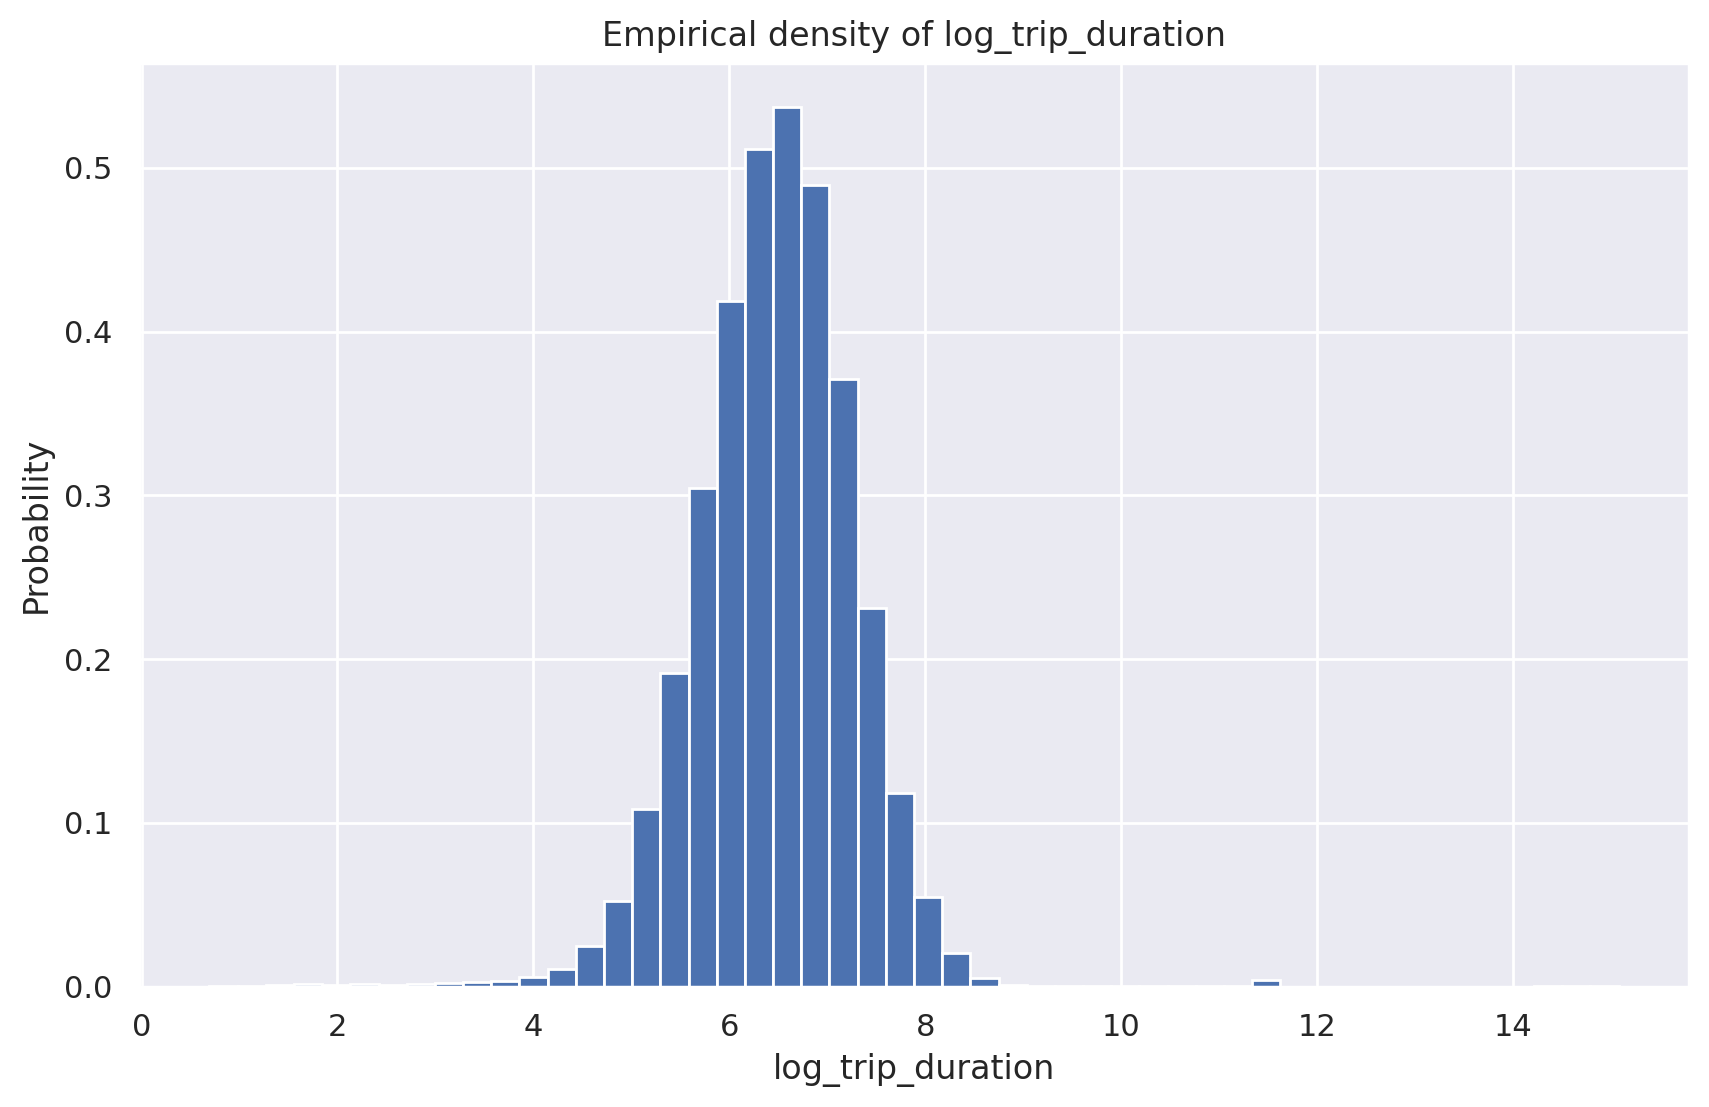

In [171]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
y_train.hist(bins=50, density=True)
plt.xlabel('log_trip_duration')
plt.ylabel('Probability')
plt.title('Empirical density of log_trip_duration')

Откинем симметрично с обеих сторон 1% наблюдений:

Text(0.5, 1.0, 'Empirical density of log_trip_duration without outliers')

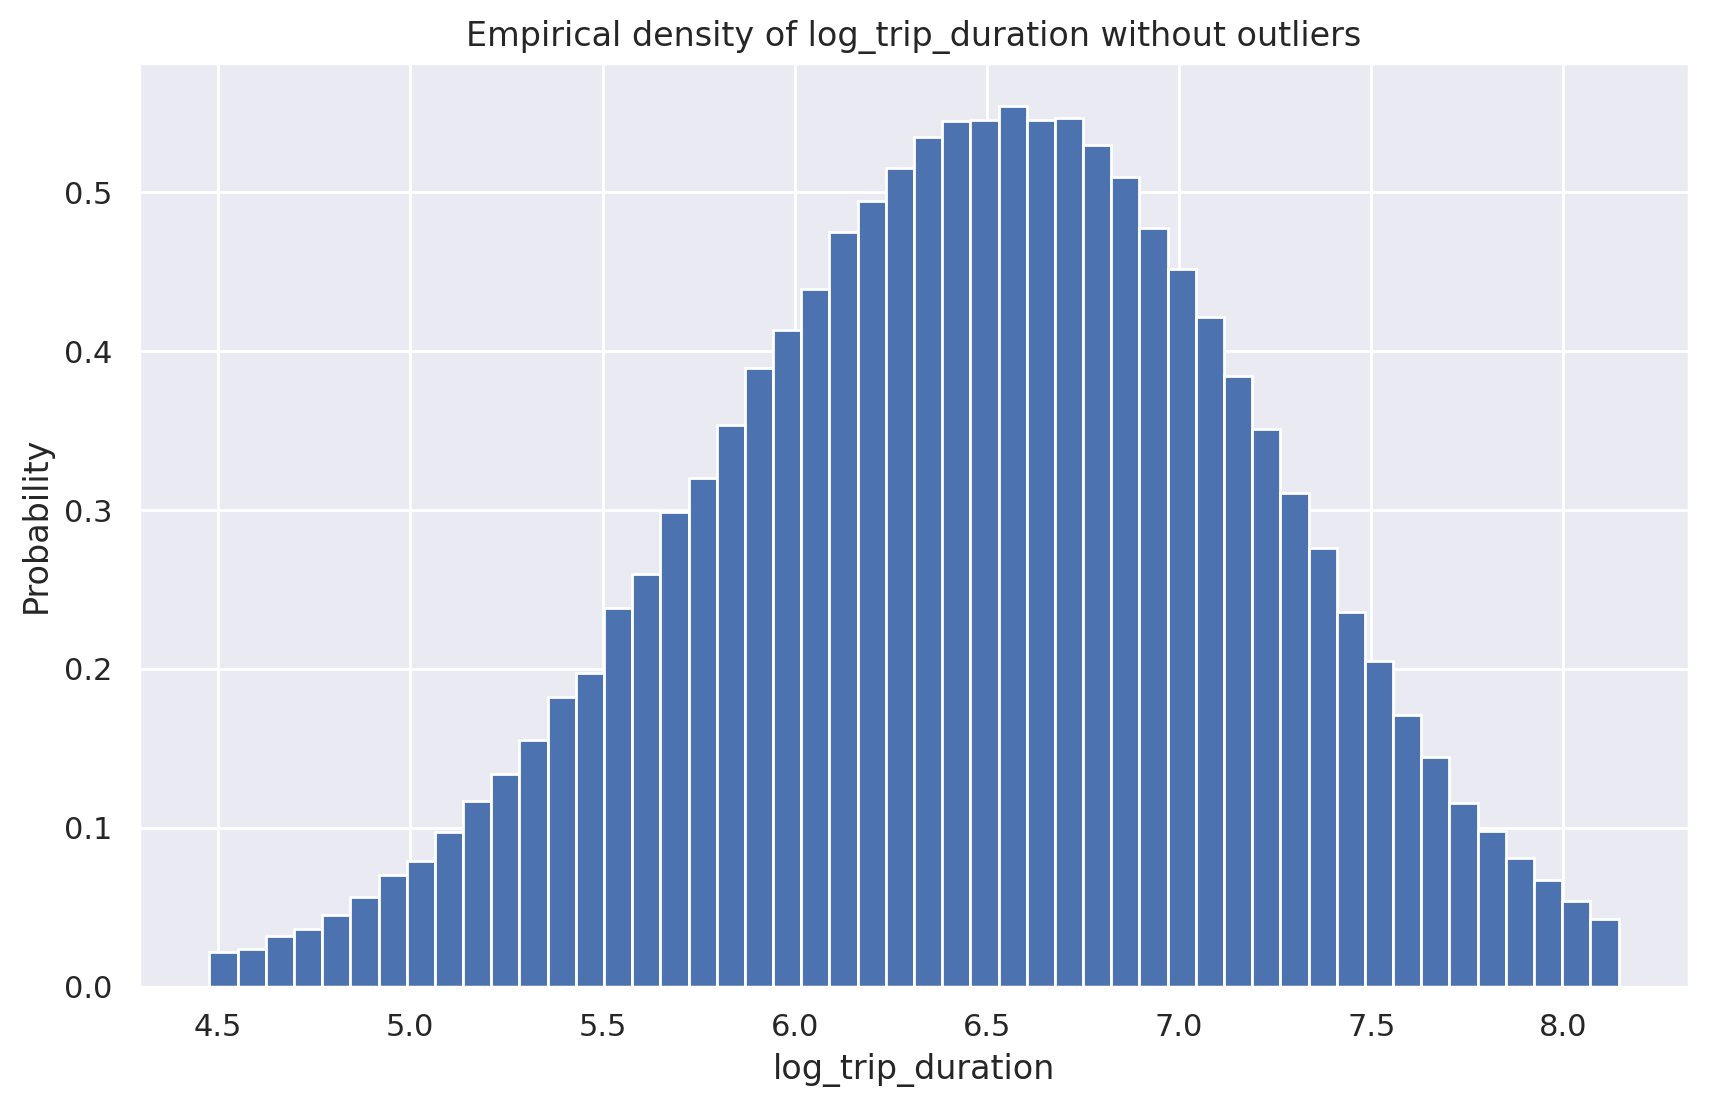

In [172]:
plt.hist(y_train[(y_train.quantile(0.01) <= y_train)
                 & (y_train <= y_train.quantile(0.99))], bins=50, density=True)[1]
plt.xlabel('log_trip_duration')
plt.ylabel('Probability')
plt.title('Empirical density of log_trip_duration without outliers')

Стало получше, запомним, какие объекты надо оставить:

In [183]:
index_len_trip = y_train[(y_train.quantile(0.01) <= y_train)
                         & (y_train <= y_train.quantile(0.99))].index

In [184]:
x_train.dtypes

id                            object
vendor_id                      int64
pickup_datetime       datetime64[ns]
passenger_count                int64
pickup_longitude             float64
pickup_latitude              float64
dropoff_longitude            float64
dropoff_latitude             float64
store_and_fwd_flag            object
date                          object
weekday                       object
hour                          object
month                         object
daynum                         int64
is_abnormal_1                  int64
is_abnormal_2                  int64
hour_int                       int64
weekday_num                   object
log_haversine                float64
rush_hour                      int64
clear_roads                    int64
from_airport                   int64
to_airport                     int64
dtype: object

Text(0.5, 1.0, 'Empirical density of Log of Haversine distance')

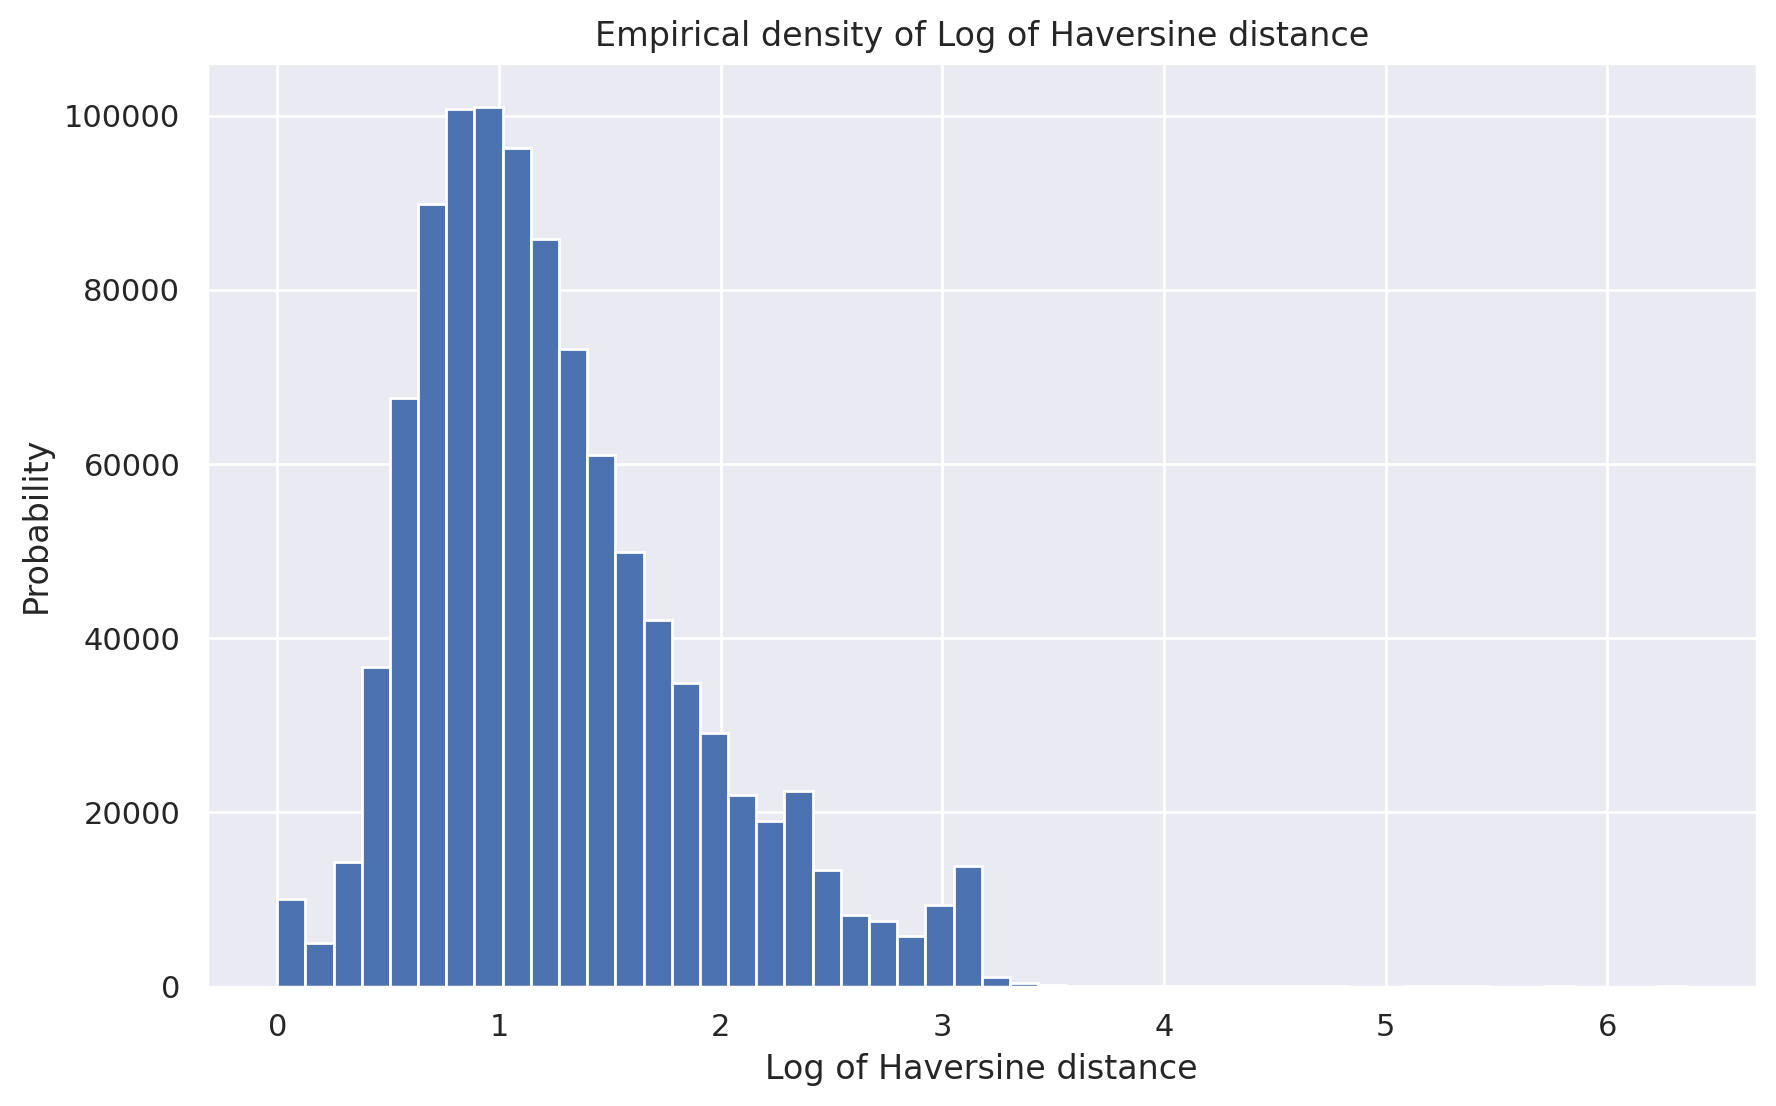

In [173]:
x_train['log_haversine'].hist(bins=50)
plt.xlabel('Log of Haversine distance')
plt.ylabel('Probability')
plt.title('Empirical density of Log of Haversine distance')

Text(0.5, 1.0, 'Empirical density of Log of Haversine distance without outliers')

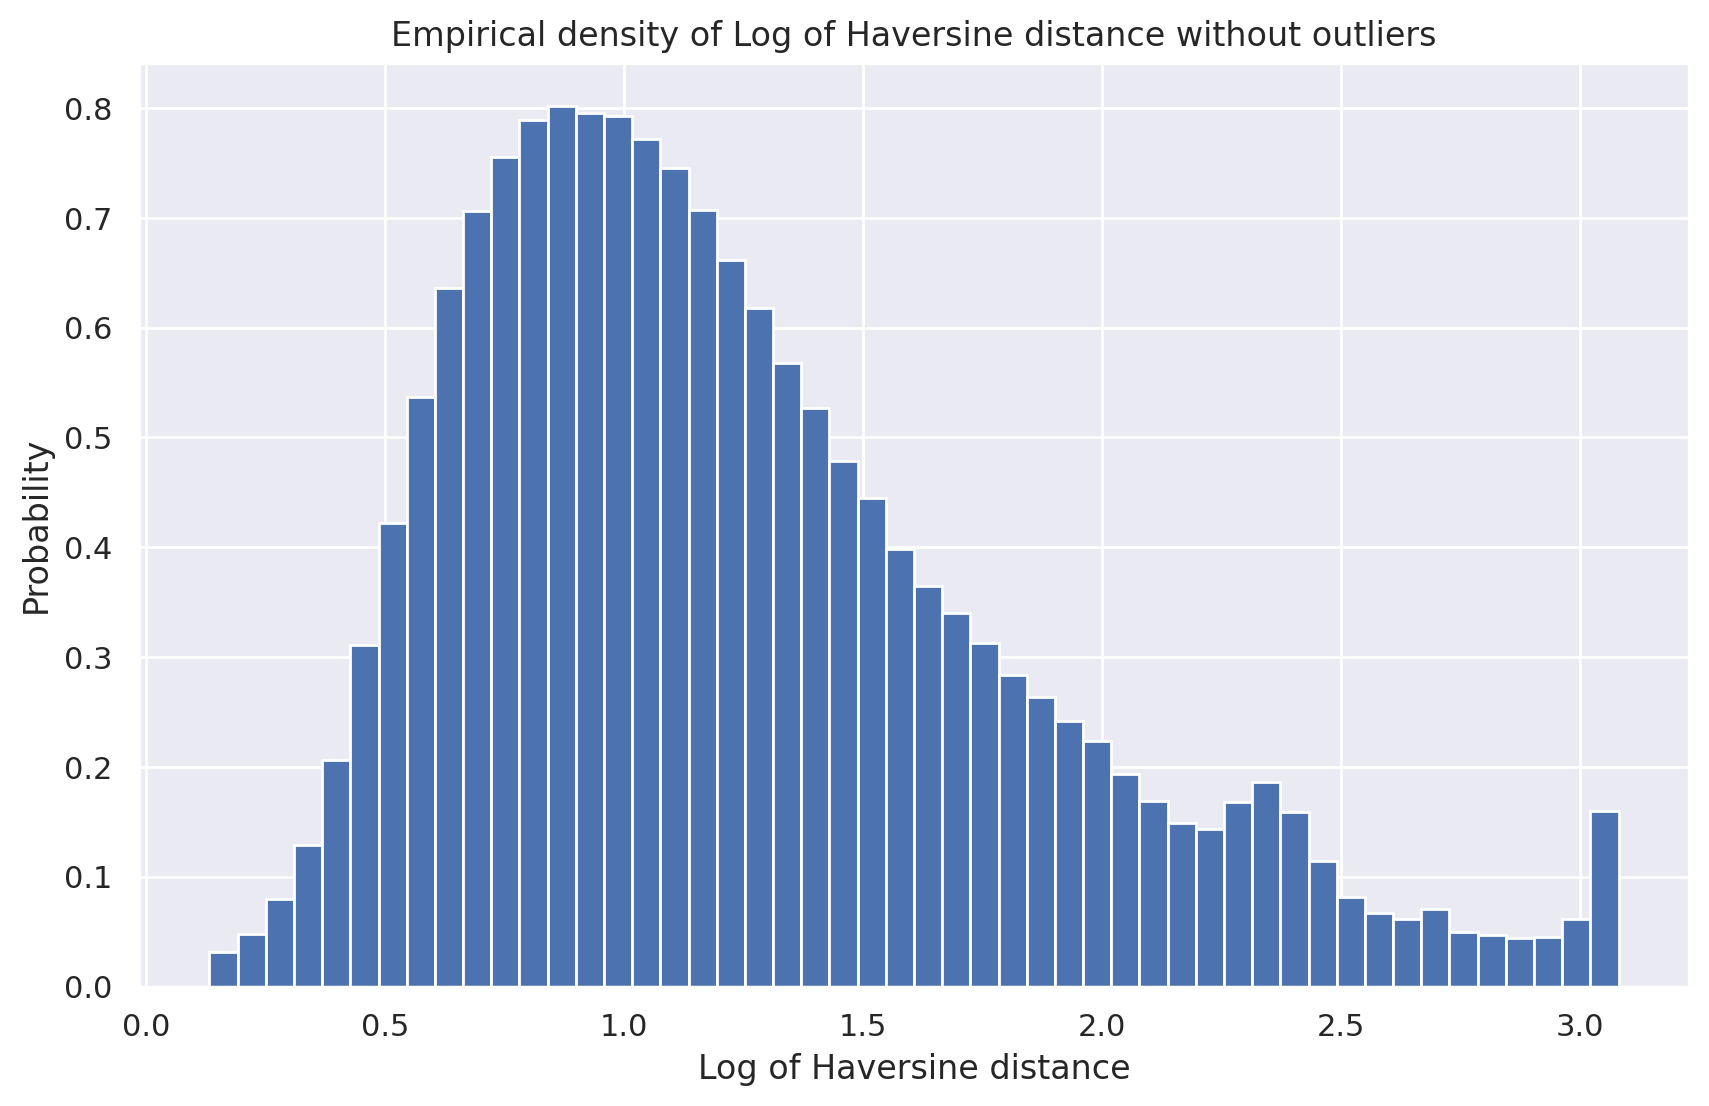

In [174]:
plt.hist(x_train[(x_train['log_haversine'].quantile(0.01) <= x_train['log_haversine'])
                 & (x_train['log_haversine'] <= x_train['log_haversine'].quantile(0.99))]['log_haversine'], bins=50, density=True)[1]
plt.xlabel('Log of Haversine distance')
plt.ylabel('Probability')
plt.title('Empirical density of Log of Haversine distance without outliers')

Опять-таки, сохраняем хорошие объекты:

In [175]:
index_dist = x_train[(x_train['log_haversine'].quantile(0.01) <= x_train['log_haversine'])
              & (x_train['log_haversine'] <= x_train['log_haversine'].quantile(0.99))].index

In [176]:
residuals = y_train - model.predict(x_train_2nd)

Text(0.5, 1.0, 'Empirical density of residuals')

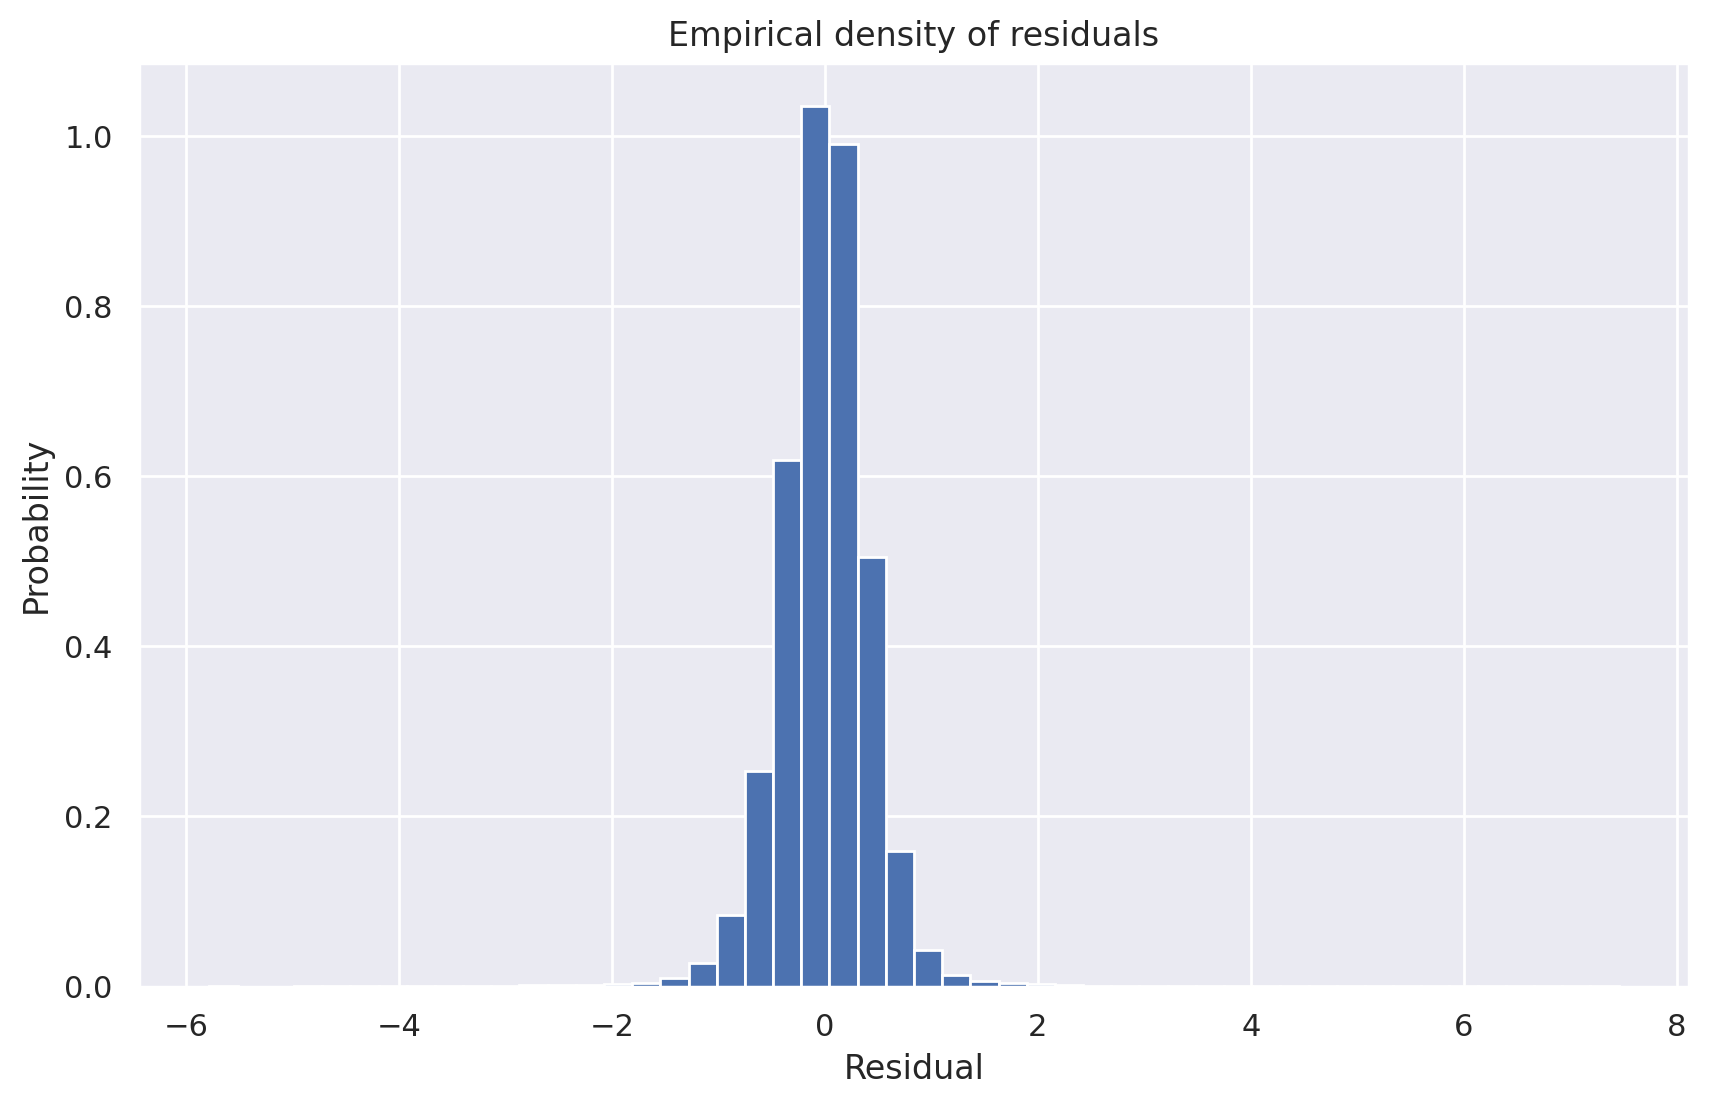

In [177]:
residuals.hist(bins=50, density=True)
plt.xlabel('Residual')
plt.ylabel('Probability')
plt.title('Empirical density of residuals')

Text(0.5, 1.0, 'Empirical density of residuals without outliers')

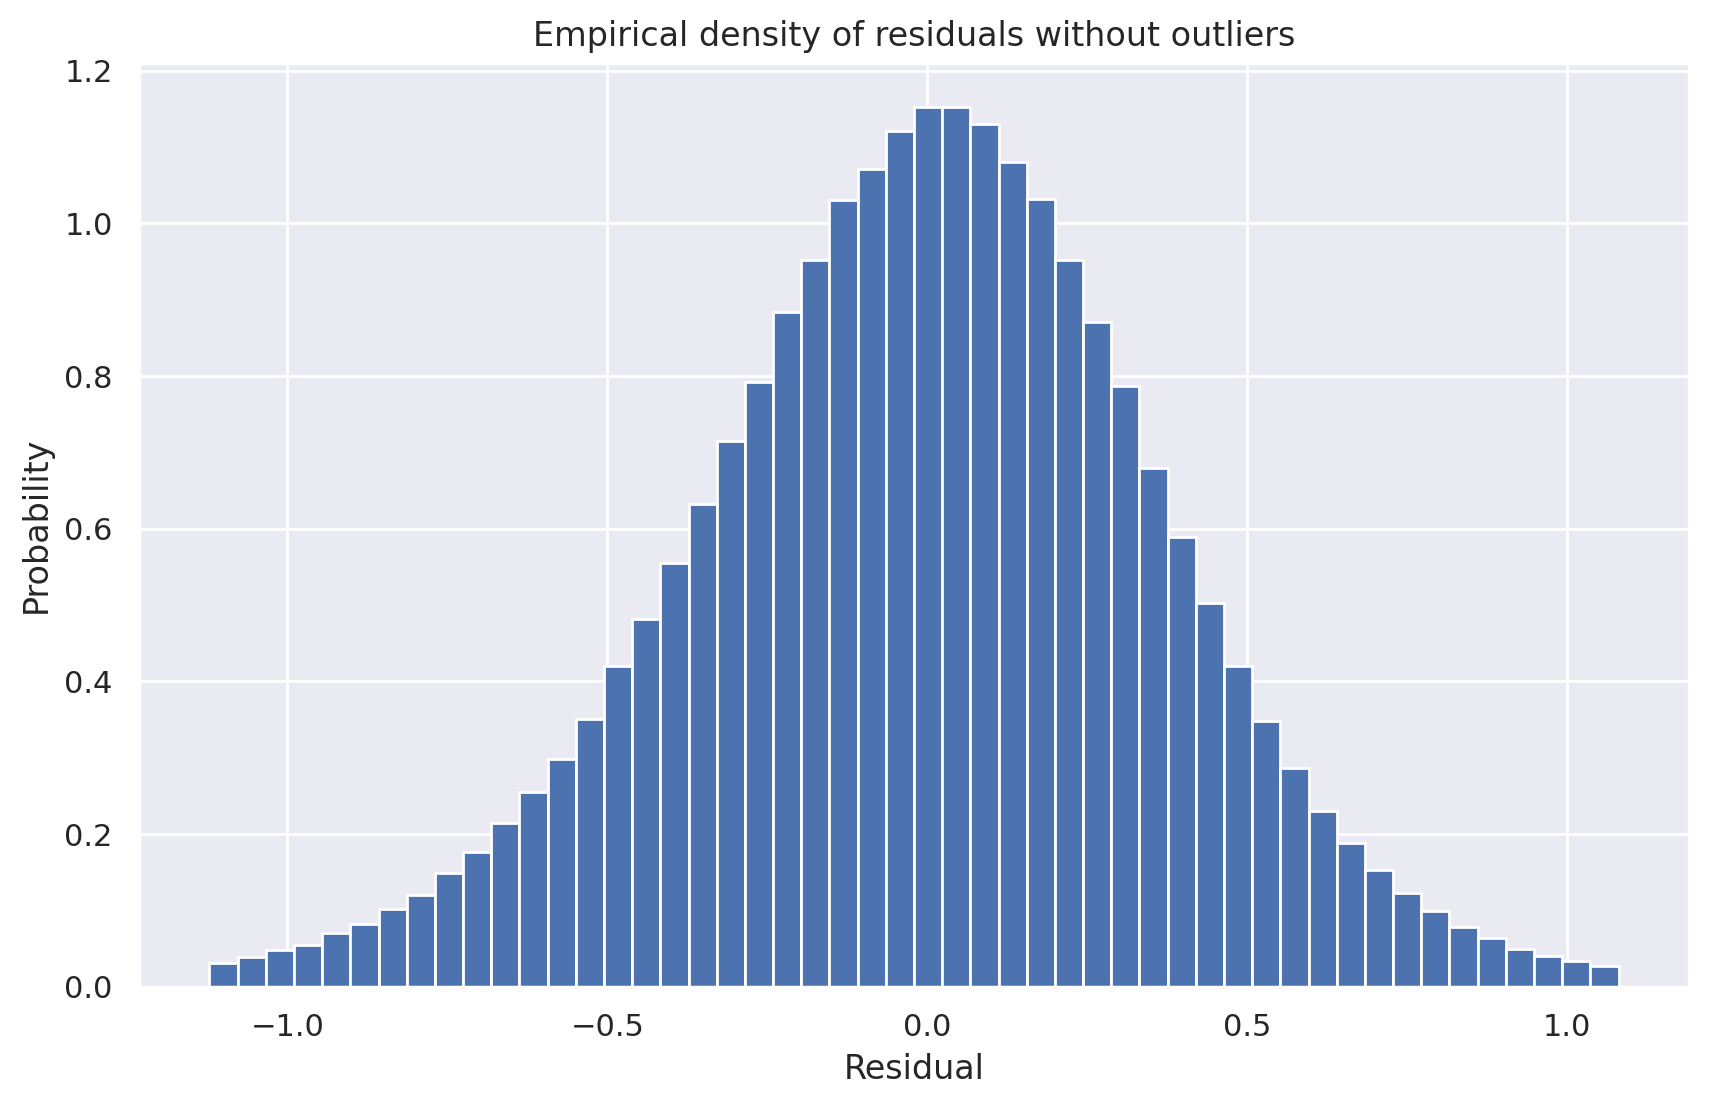

In [178]:
plt.hist(residuals[(residuals.quantile(0.01) <= residuals)
                 & (residuals <= residuals.quantile(0.99))], bins=50, density=True)[1]
plt.xlabel('Residual')
plt.ylabel('Probability')
plt.title('Empirical density of residuals without outliers')

Вполне норм, оставляем так:

In [179]:
index_residuals = residuals[(residuals.quantile(0.01) <= residuals)
                                    & (residuals <= residuals.quantile(0.99))].index

In [185]:
good_indices = index_residuals.intersection(index_dist.intersection(index_len_trip))

x_train_cleared = x_train.loc[good_indices, :]
y_train_cleared = y_train.loc[good_indices]

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [186]:
print(x_train_cleared[['id', 'rush_hour']].groupby('rush_hour').count()['id'])
print(x_train_cleared[['id', 'clear_roads']].groupby('clear_roads').count()['id'])

rush_hour
0    562981
1    416914
Name: id, dtype: int64
clear_roads
0    891390
1     88505
Name: id, dtype: int64


In [187]:
print(x_train_cleared[['id', 'weekday']].groupby('weekday').count()['id'])
print(x_train_cleared[['id', 'month']].groupby('month').count()['id'])

weekday
0 Sunday       131131
1 Monday       125714
2 Tuesday      136297
3 Wednesday    140804
4 Thursday     146549
5 Friday       150286
6 Saturday     149114
Name: id, dtype: int64
month
01 January     154437
02 February    161138
03 March       172229
04 April       169266
05 May         166442
06 June        156383
Name: id, dtype: int64


In [188]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

In [189]:
print(x_train_cleared[['id', 'from_airport']].groupby('from_airport').count()['id'])
print(x_train_cleared[['id', 'to_airport']].groupby('to_airport').count()['id'])

from_airport
0    953862
1     26033
Name: id, dtype: int64
to_airport
0    969091
1     10804
Name: id, dtype: int64


In [190]:
x_train_cleared['airport_tag'] = x_train_cleared['from_airport'] | x_train_cleared['to_airport']

In [191]:
x_train_cleared = x_train_cleared.drop(columns=['from_airport', 'to_airport'])

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

In [192]:
def add_features_fourth_round(df: pd.DataFrame) -> pd.DataFrame:
    df = add_features_second_round(df)
    df['airport_tag'] = df['from_airport'] | df['to_airport']
    return df.drop(columns=['from_airport', 'to_airport'])

In [193]:
transformer_rectangles = MapGridTransformer()
x_train_4th = transformer_rectangles.fit_transform(add_features_fourth_round(x_train_cleared))
x_test_4th = transformer_rectangles.transform(add_features_fourth_round(x_test))

<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])


In [194]:
numeric = ['daynum', 'log_haversine']
categorical = ['hour', 'month', 'weekday', 'is_abnormal_1', 'is_abnormal_2',
               'airport_tag', 'rush_hour', 'clear_roads', 'cell_pickup', 'cell_dropoff']
coordinates_features = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']

column_transformer_4th_round = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_4th_round = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_4th_round),
    ('regression', Ridge())
])

In [195]:
model_round_4 = pipeline_4th_round.fit(x_train_4th, y_train_cleared)

In [196]:
print("RMSLE after 4th round of features:", rmsle(y_test, model_round_4.predict(x_test_4th)))

RMSLE after 4th round of features: 0.474813430209157


**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [197]:
x_train_4th.columns

Index(['date', 'weekday', 'hour', 'month', 'daynum', 'is_abnormal_1',
       'is_abnormal_2', 'log_haversine', 'rush_hour', 'clear_roads',
       'airport_tag', 'cell_pickup', 'cell_dropoff'],
      dtype='object')

In [198]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print("Number of features before OHE:", len(x_train_4th.columns))
print('Number of features after OHE:', column_transformer_4th_round.transform(x_train_4th).shape[1])

Number of features before OHE: 13
Number of features after OHE: 343


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [199]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
pipeline_4th_round_lasso = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_4th_round),
    ('regression', Lasso())
])
model_round_4_lasso = pipeline_4th_round_lasso.fit(x_train_4th, y_train_cleared)

In [200]:
print("RMSLE after 4th round of features using Lasso regression:",
      rmsle(y_test, model_round_4_lasso.predict(x_test_4th)))

RMSLE after 4th round of features using Lasso regression: 0.7983816173168877


Из коробки лучше работает Ridge

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [201]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
x_train_idk, x_val_idk, y_train_idk, y_val_idk = train_test_split(x_train_cleared, y_train_cleared, test_size=0.2, random_state=42)

In [202]:
alphas = np.logspace(-4, 4, 15)

column_transformer_val = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

x_train_idk_with_features = column_transformer_val.fit_transform(
    transformer_rectangles.fit_transform(add_features_fourth_round(x_train_idk)))
x_val_idk_with_features = column_transformer_val.transform(
    transformer_rectangles.transform(add_features_fourth_round(x_val_idk)))

def find_best_params(x_train: pd.DataFrame, x_val: pd.DataFrame,
                     y_train: pd.DataFrame, y_val: pd.DataFrame,
                     alphas: np.array, model):
    transformer_rectangles = MapGridTransformer()
    rmsle_scores = []
    null_coeffs_history = []
    best_alpha = None
    best_rmsle = None
    for alpha in alphas:
        model_alpha = model(alpha=alpha)
        model_alpha = model_alpha.fit(x_train, y_train)
        rmsle_lasso_alpha = rmsle(y_val_idk, model_alpha.predict(x_val))
        rmsle_scores.append(rmsle_lasso_alpha)
        null_coeffs_history.append(len(model_alpha.coef_[model_alpha.coef_ == 0]))
        if best_alpha is None or best_rmsle > rmsle_lasso_alpha:
            best_alpha = alpha
            best_rmsle = rmsle_lasso_alpha
    return rmsle_scores, best_alpha, null_coeffs_history

rmsle_lasso, best_alpha_lasso, null_coeffs_history = find_best_params(x_train_idk_with_features,
                                        x_val_idk_with_features,
                                        y_train_idk,
                                        y_val_idk, alphas, Lasso)
rmsle_ridge, best_alpha_ridge, _ = find_best_params(x_train_idk_with_features,
                                                 x_val_idk_with_features,
                                                 y_train_idk,
                                                 y_val_idk, alphas, Ridge)


<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])


In [203]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
print('Best alpha for Lasso model:', best_alpha_lasso)
print('Best alpha for Ridge model:', best_alpha_ridge)

Best alpha for Lasso model: 0.0001
Best alpha for Ridge model: 13.89495494373136


Text(0.5, 1.0, 'RMSLE on validation set with different $\\alpha$ using Ridge')

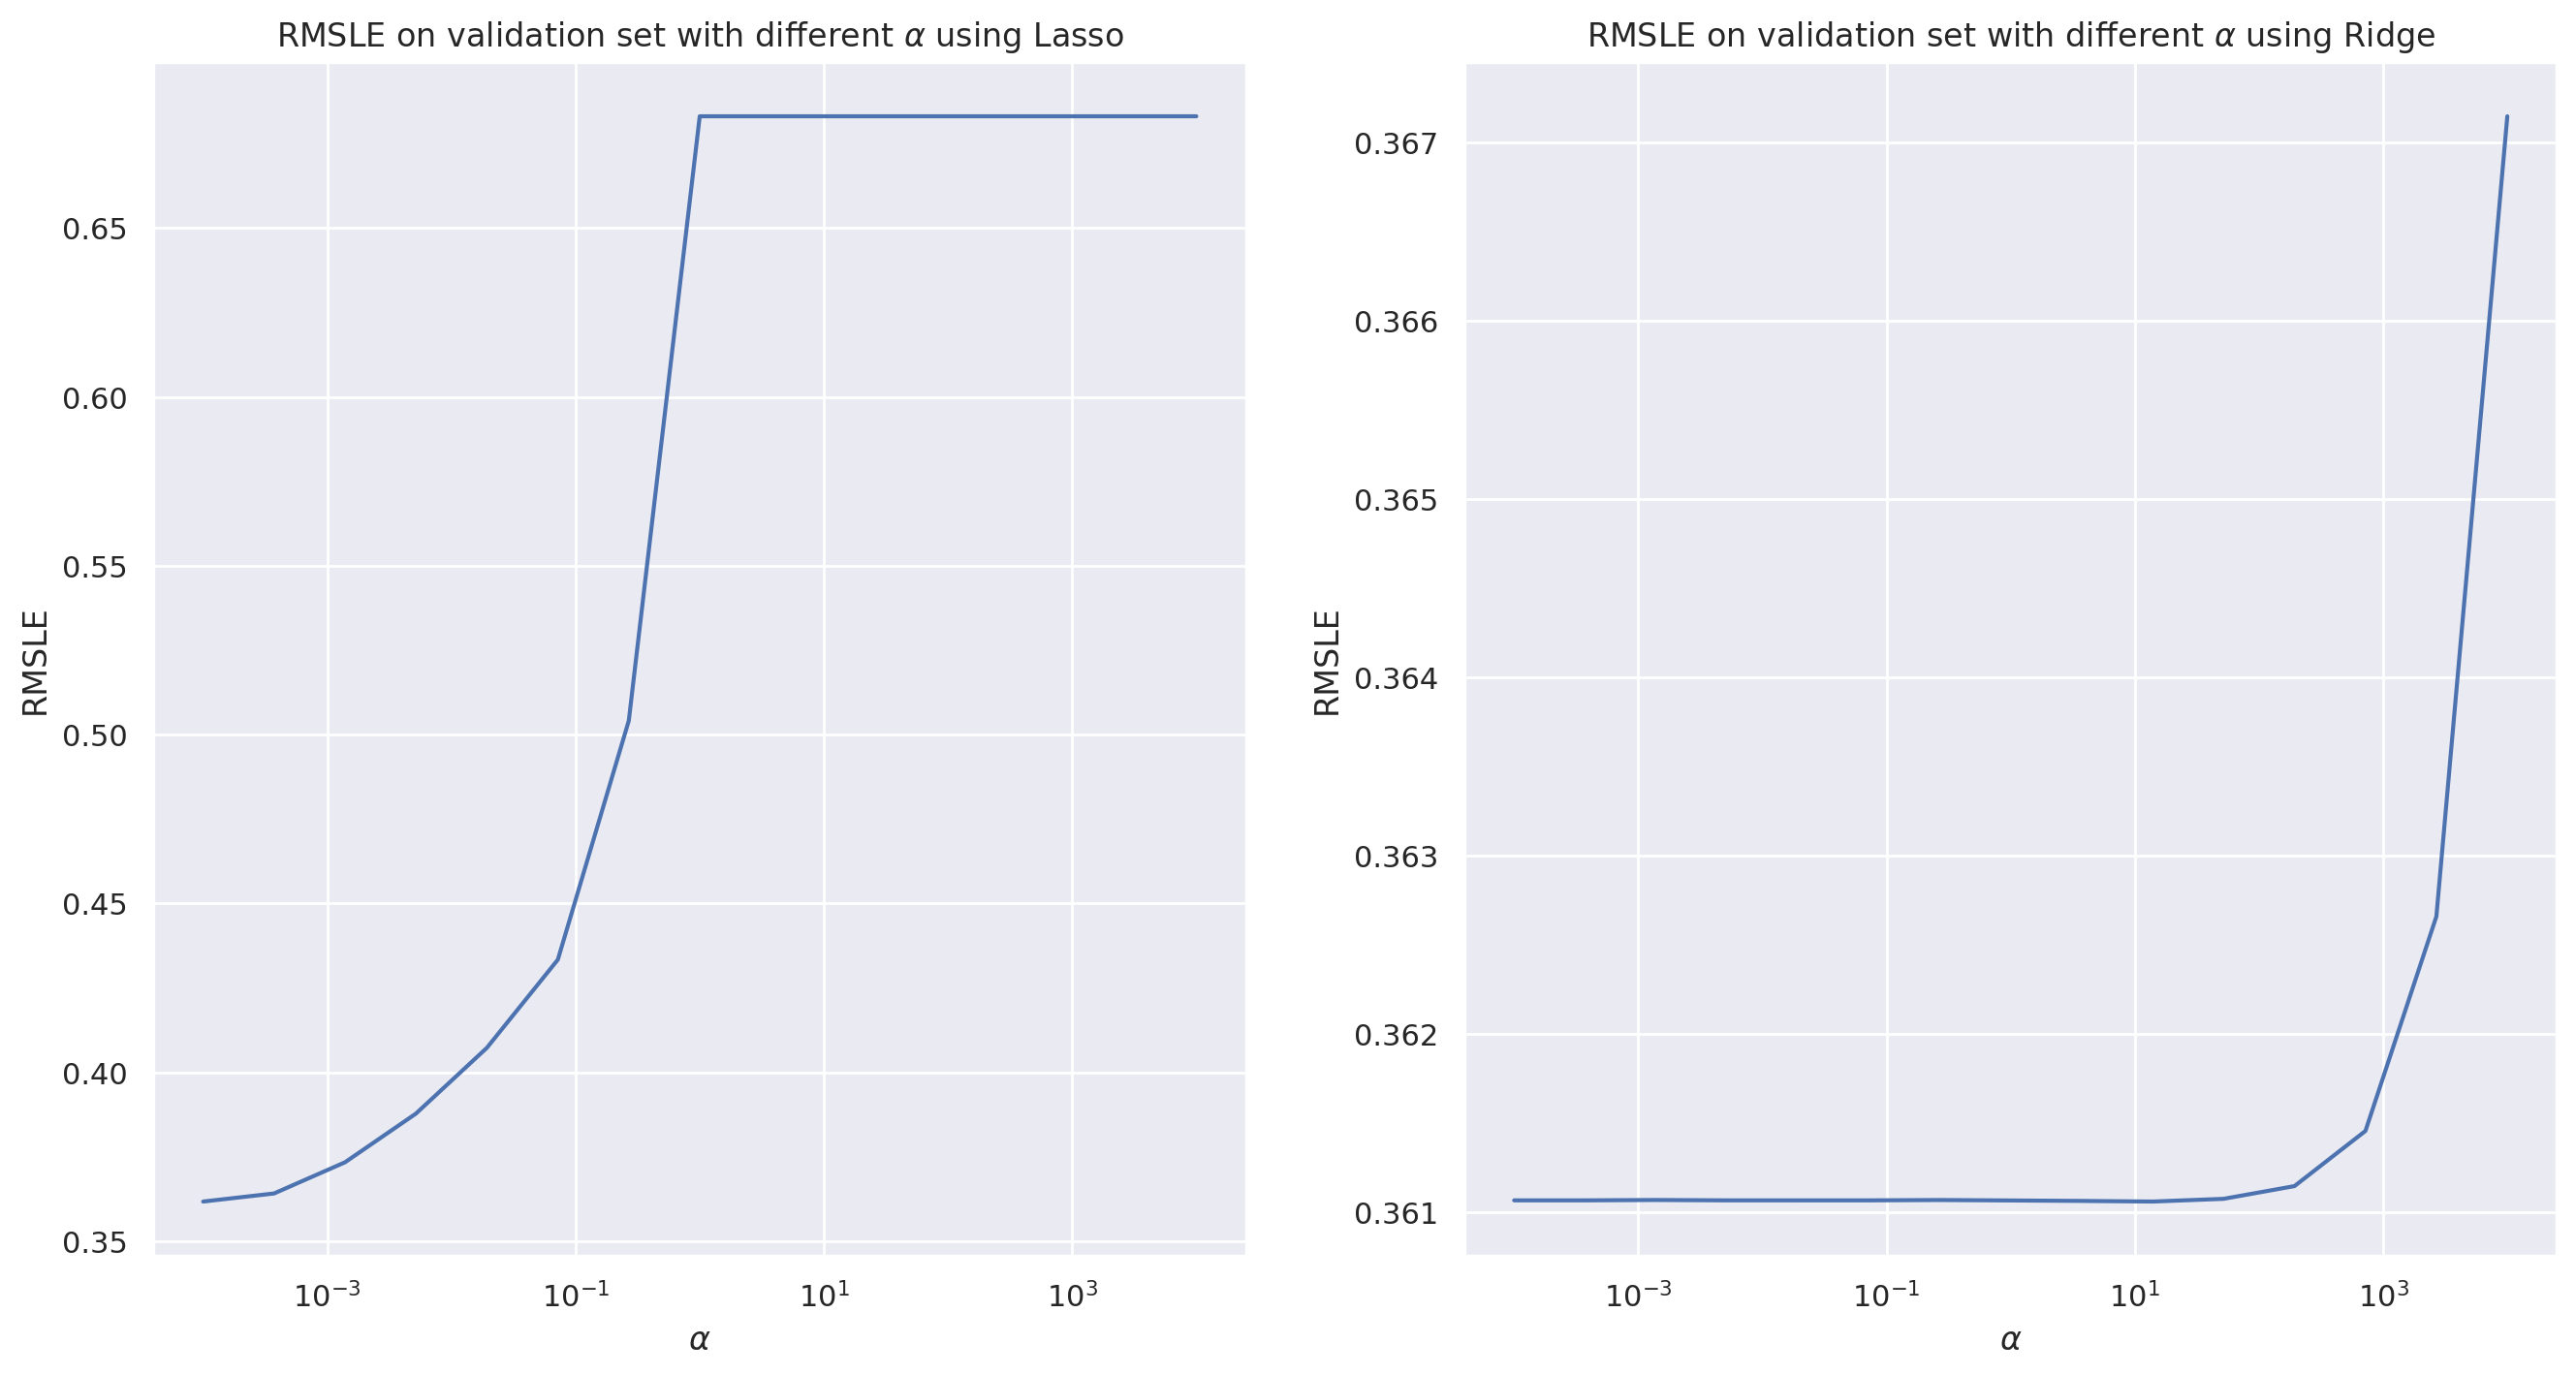

In [216]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(alphas, rmsle_lasso)
ax[0].set_xscale('log')
ax[0].set_xlabel('$\\alpha$')
ax[0].set_ylabel('RMSLE')
ax[0].set_title("RMSLE on validation set with different $\\alpha$ using Lasso")
ax[1].plot(alphas, rmsle_ridge)
ax[1].set_xscale('log')
ax[1].set_xlabel('$\\alpha$')
ax[1].set_ylabel('RMSLE')
ax[1].set_title("RMSLE on validation set with different $\\alpha$ using Ridge")

In [205]:
x_test_idk_with_features = column_transformer_val.transform(
    transformer_rectangles.fit_transform(add_features_fourth_round(x_test)))

model_ridge = Ridge(alpha=best_alpha_ridge).fit(x_train_idk_with_features, y_train_idk)
model_lasso = Lasso(alpha=best_alpha_lasso).fit(x_train_idk_with_features, y_train_idk)

<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])


In [206]:
print("RMSLE after 4th round of features and tuning alpha using Lasso regression:",
      rmsle(y_test, model_lasso.predict(x_test_idk_with_features)))
print("RMSLE after 4th round of features and tuning alpha using Ridge regression:",
      rmsle(y_test, model_ridge.predict(x_test_idk_with_features)))

RMSLE after 4th round of features and tuning alpha using Lasso regression: 0.47897994113453435
RMSLE after 4th round of features and tuning alpha using Ridge regression: 0.47922662661273674


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

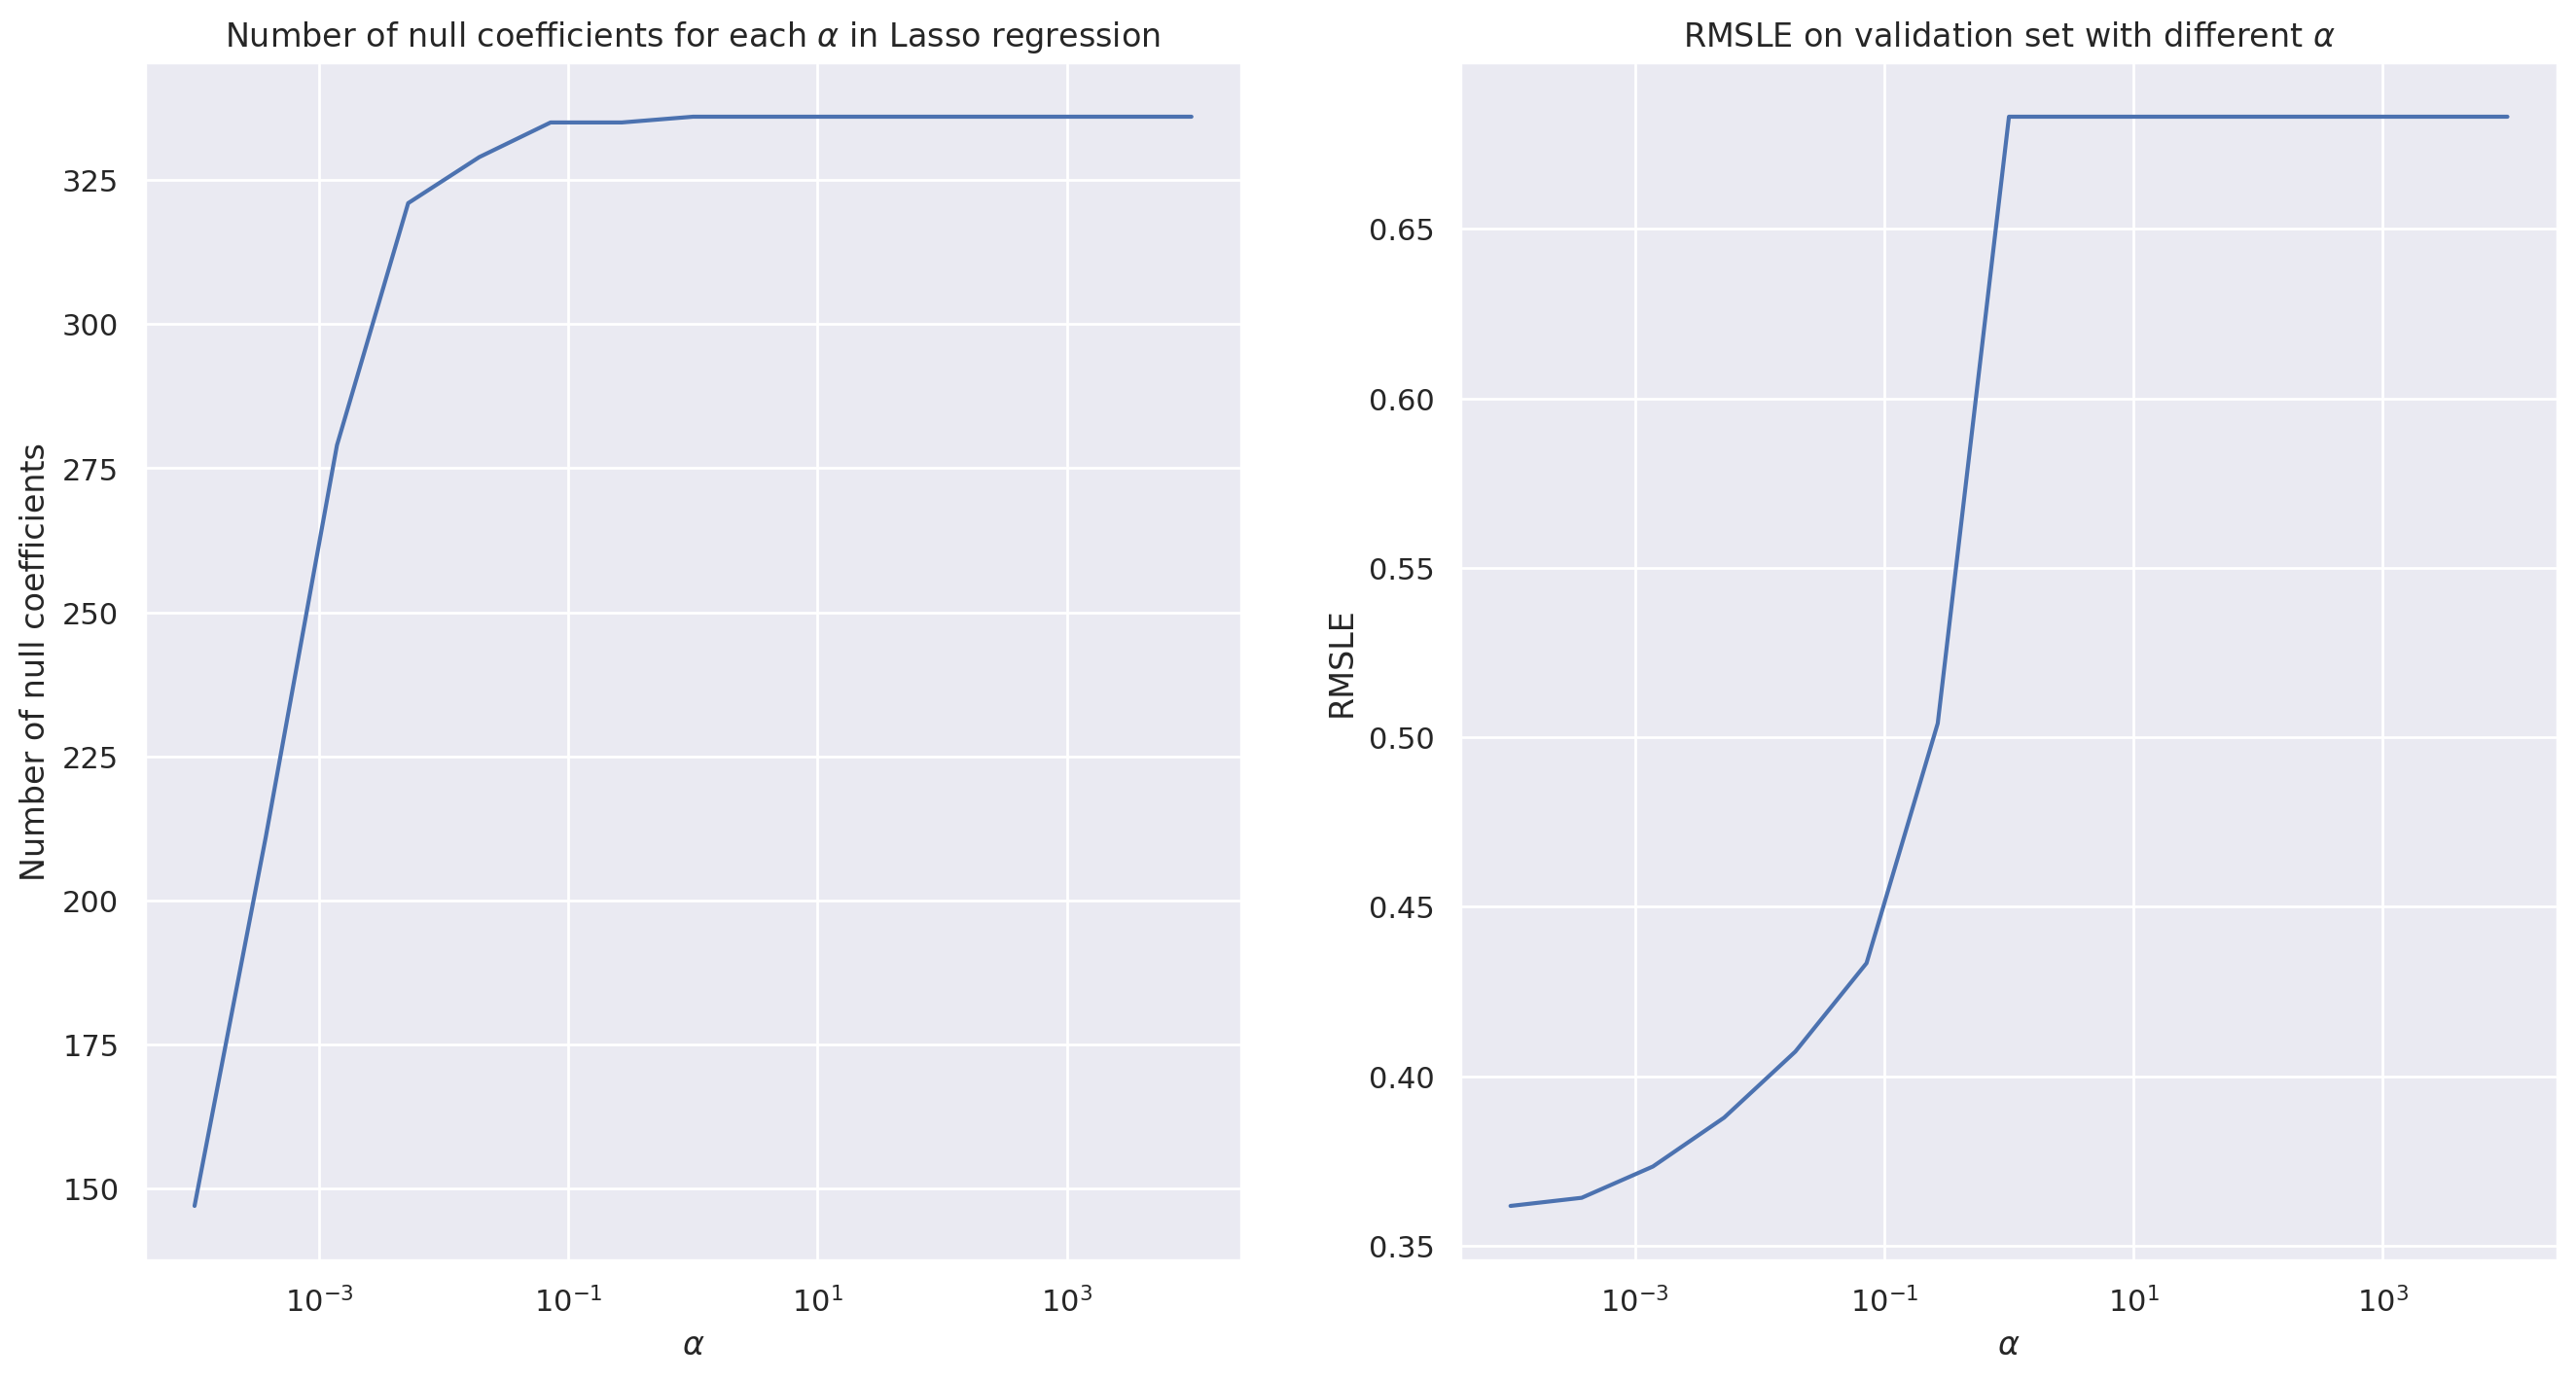

In [214]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))
ax[0].plot(alphas, null_coeffs_history)
ax[0].set_xscale('log')
ax[0].set_xlabel('$\\alpha$')
ax[0].set_ylabel('Number of null coefficients')
ax[0].set_title("Number of null coefficients for each $\\alpha$ in Lasso regression")
ax[1].plot(alphas, rmsle_lasso) # так как мы зафиксировали сид и выборка не меняется, то результаты остаются теми же
ax[1].set_xlabel('$\\alpha$')
ax[1].set_ylabel('RMSLE')
ax[1].set_title("RMSLE on validation set with different $\\alpha$")
ax[1].set_xscale('log')

In [238]:
print(x_test_idk_with_features.shape[1])

336


Методом пристального взгяда видим, что мы потеряем мало в качестве, если захотим выкинуть хотя бы не меньше половины признаков

<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

По идее, признак "пара признаков" не представляется как линейная комбинация признаков, поэтому эту информацию линейная модель не может "вытащить".

In [217]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
x_train_groups = transformer_rectangles.fit_transform(x_train_cleared).groupby(['cell_pickup', 'cell_dropoff']).count().reset_index()[['cell_pickup', 'cell_dropoff', 'id']]

In [218]:
most_popular_cells = x_train_groups.sort_values('id', ascending=False).head(100)[['cell_pickup', 'cell_dropoff']]

In [219]:
def code_cells(df):
    return ((transformer_rectangles.num_rows * transformer_rectangles.num_cols) * (df['cell_pickup'] + 1) + df['cell_dropoff'] + 1)

In [220]:
cell_values = (code_cells(most_popular_cells)).unique()

In [221]:
def add_cell_dynamic_feature(df: pd.DataFrame, cell_values) -> pd.DataFrame:
    df = transformer_rectangles.transform(add_features_fourth_round(df))
    df['cell_dynamic'] = -1
    cond = (code_cells(df)).isin(cell_values)
    df.loc[cond, 'cell_dynamic'] = code_cells(df)
    return df

In [222]:
x_train_cleared_dynamic = add_cell_dynamic_feature(x_train_cleared, cell_values)
x_test_cleared_dynamic = add_cell_dynamic_feature(x_test, cell_values)

<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [223]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
categorical = ['hour', 'month', 'weekday', 'is_abnormal_1', 'is_abnormal_2',
               'airport_tag', 'rush_hour', 'clear_roads', 'cell_pickup',
               'cell_dropoff', 'cell_dynamic']

column_transformer_cells_dynamic_round = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_cells_dynamic_round = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_cells_dynamic_round),
    ('regression', Ridge(alpha=best_alpha_ridge))
])

In [224]:
x_train_dynamic_features = column_transformer_cells_dynamic_round.fit_transform(
        add_cell_dynamic_feature(x_train_idk, cell_values))
x_val_dynamic_features = column_transformer_cells_dynamic_round.transform(
    add_cell_dynamic_feature(x_val_idk, cell_values))

_, best_alpha_dynamic, _ = find_best_params(x_train_dynamic_features,
                                            x_val_dynamic_features,
                                            y_train_idk,
                                            y_val_idk, alphas, Ridge)

<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])


In [225]:
model_round_cells_dynamic = Ridge(best_alpha_dynamic).fit(x_train_dynamic_features, y_train_idk)

In [226]:
x_test_cleared_dynamic = column_transformer_cells_dynamic_round.transform(x_test_cleared_dynamic)

In [227]:
print("RMSLE after adding cross-cell feature using Ridge regression:",
      rmsle(y_test, model_round_cells_dynamic.predict(x_test_cleared_dynamic)))

RMSLE after adding cross-cell feature using Ridge regression: 0.4729131734228207


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

Манхэттенское расстояние - $L_1$-норма разницы координат; оно называется так, потому что в Манхэттене улицы построены перпендикулярно друг другу, а сам Манхэттен выглядит как сетка. Так как почти все поездки были совершены в Манхэттене, то Манхэттенское расстояние - это "почти честное" расстояние поездки, которое приближает честное расстояние поездки лучше, чем haversine

In [228]:
sin_29 = np.sin(np.pi * 29 / 180)
cos_29 = np.cos(np.pi * 29 / 180)
x_train_cleared['dropoff_longitude_manhattan'] = cos_29 * x_train_cleared['dropoff_longitude'] + sin_29 * x_train_cleared['dropoff_latitude']
x_train_cleared['dropoff_latitude_manhattan'] = -sin_29 * x_train_cleared['dropoff_longitude'] + cos_29 * x_train_cleared['dropoff_latitude']
x_train_cleared['pickup_longitude_manhattan'] = cos_29 * x_train_cleared['pickup_longitude'] + sin_29 * x_train_cleared['pickup_latitude']
x_train_cleared['pickup_latitude_manhattan'] = -sin_29 * x_train_cleared['pickup_longitude'] + cos_29 * x_train_cleared['pickup_latitude']

x_train_cleared['manhattan_dist'] = np.abs(x_train_cleared['dropoff_longitude_manhattan'] - x_train_cleared['pickup_longitude_manhattan']) + np.abs(x_train_cleared['dropoff_latitude_manhattan'] - x_train_cleared['pickup_latitude_manhattan'])
x_train_cleared['log_manhattan_dist'] = np.log1p(x_train_cleared['manhattan_dist'])

In [229]:
df_train_cleared = df_train.loc[good_indices, :]

In [230]:
print('Correlation between target and haversine is:', df_train_cleared['haversine'].corr(df_train_cleared['log_trip_duration']))
print('Correlation between target and log_haversine is:', df_train_cleared['log_haversine'].corr(df_train_cleared['log_trip_duration']))
print('Correlation between target and manhattan_dist is:', x_train_cleared['manhattan_dist'].corr(y_train_cleared))
print('Correlation between target and log_manhattan_dist is:', x_train_cleared['log_manhattan_dist'].corr(y_train_cleared))
print('Correlation between log_manhattan_dist and log_haversine is:', df_train_cleared['log_haversine'].corr(x_train_cleared['log_manhattan_dist']))

Correlation between target and haversine is: 0.6668053331994588
Correlation between target and log_haversine is: 0.7812684798768842
Correlation between target and manhattan_dist is: 0.6408138620287247
Correlation between target and log_manhattan_dist is: 0.6558503094622183
Correlation between log_manhattan_dist and log_haversine is: 0.9133703824324745


In [231]:
x_train_cleared = x_train_cleared.drop(columns=['manhattan_dist', 'log_manhattan_dist'])

In [232]:
def add_manhattan_dist_feature(df: pd.DataFrame, cell_values) -> pd.DataFrame:
    sin_29 = np.sin(np.pi * 29 / 180)
    cos_29 = np.cos(np.pi * 29 / 180)
    df['dropoff_longitude_manhattan'] = cos_29 * df['dropoff_longitude'] + sin_29 * df['dropoff_latitude']
    df['dropoff_latitude_manhattan'] = -sin_29 * df['dropoff_longitude'] + cos_29 * df['dropoff_latitude']
    df['pickup_longitude_manhattan'] = cos_29 * df['pickup_longitude'] + sin_29 * df['pickup_latitude']
    df['pickup_latitude_manhattan'] = -sin_29 * df['pickup_longitude'] + cos_29 * df['pickup_latitude']
    df['log_manhattan_dist'] = np.log1p(np.abs(df['dropoff_longitude_manhattan'] - df['pickup_longitude_manhattan']) + np.abs(df['dropoff_latitude_manhattan'] - df['pickup_latitude_manhattan']))
    return add_cell_dynamic_feature(df.drop(columns=[
        'dropoff_longitude_manhattan', 'dropoff_latitude_manhattan',
        'pickup_longitude_manhattan', 'pickup_latitude_manhattan']), cell_values)

In [233]:
x_train_cleared_manhattan = add_manhattan_dist_feature(x_train_cleared, cell_values)
x_test_cleared_manhattan = add_manhattan_dist_feature(x_test, cell_values)

<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])
<ipython-input-156-1c243dab1fa9>:8: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'daynum'] = pd.to_numeric(df['daynum'])



https://trefethen.net/2013/09/29/manhattan-is-tilted-at-a-29-degree-angle/

Картинка с осями во вложении

In [234]:
print(x_train_cleared_manhattan.dtypes, x_train_cleared_dynamic.dtypes, sep='\n')

date                   object
weekday                object
hour                   object
month                  object
daynum                  int64
is_abnormal_1           int64
is_abnormal_2           int64
log_haversine         float64
rush_hour               int64
clear_roads             int64
airport_tag             int64
cell_pickup             int64
cell_dropoff            int64
log_manhattan_dist    float64
cell_dynamic            int64
dtype: object
date              object
weekday           object
hour              object
month             object
daynum             int64
is_abnormal_1      int64
is_abnormal_2      int64
log_haversine    float64
rush_hour          int64
clear_roads        int64
airport_tag        int64
cell_pickup        int64
cell_dropoff       int64
cell_dynamic       int64
dtype: object


In [235]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
numeric = ['daynum', 'log_manhattan_dist', 'log_haversine']

column_transformer_manhattan_round = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline_manhattan_round = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer_manhattan_round),
    ('regression', Ridge(alpha=best_alpha_dynamic))
])

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [236]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
model_round_manhattan = pipeline_manhattan_round.fit(x_train_cleared_manhattan, y_train_cleared)

In [237]:
print("RMSLE after adding log-Manhattan distance using Ridge regression:",
      rmsle(y_test, model_round_manhattan.predict(x_test_cleared_manhattan)))

RMSLE after adding log-Manhattan distance using Ridge regression: 0.46643201485544955


Стало лучше, но не сильно, потому что:

1. Не все поездки соверщаются на территории Манхэттена
2. На время поездки может влиять также загруженность дорог, "скилл" водителя и прочие факторы, которые наша модель не учитывает

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

потрогаю траву лучше

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.

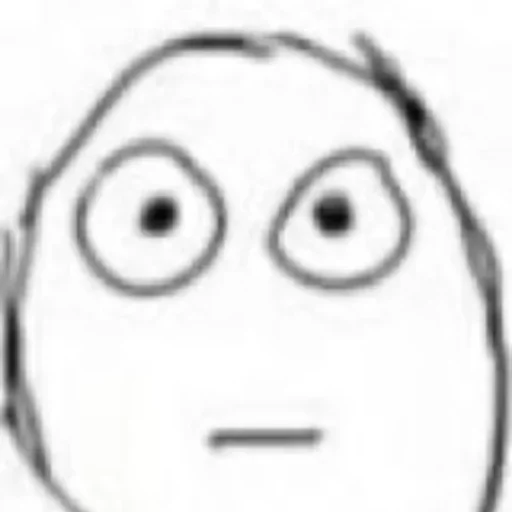